In [45]:
%matplotlib inline
import signac
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from pathlib import Path
from itertools import product
import pandas as pd
import json
from copy import deepcopy
sns.set(context="notebook", style="whitegrid",font_scale=1.2,palette='viridis')


In [2]:
base = './results/scripts_all_1/'
# base = './results/scripts/'
fn_projects = {
    'ri':base+'radial_integral',
    'sph':base+'spherical_harmonics',
    'se':base+'spherical_expansion',
    'si':base+'spherical_invariants',
}

In [3]:
queries = {}
dfs = {}

In [4]:
names = [
    'qm9',
    'molecular_crystals',
    'silicon_bulk',
    'methane_liquid',
    'methane_sulfonic'
]
radial_basis = ['GTO','DVR','GTO Spline','DVR Spline']
grads = [True, False]

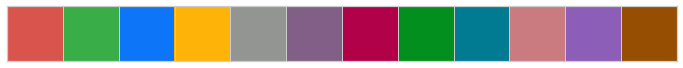

In [5]:
colors = ["pale red","medium green",
          "deep sky blue", "amber", "grey",  "dusty purple",
          "raspberry","emerald green","ocean","dirty pink",
         "deep lavender","warm brown"]
palette = sns.xkcd_palette(colors)
sns.palplot(palette)

In [6]:
def format_contour(data,x,y,z,title_values):
    df = data.pivot_table(index=y, columns=x, values=z)
    df = df.sort_index('index',ascending=False) 
    ax = sns.heatmap(df,cmap='viridis',square=True, cbar_kws={'label': z})
    title = ' / '.join([k+':'+str(data.iloc[0][k]) for k in title_values])
    ax.set_title(title,pad=20)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    return ax

# radial_integral

## Radial integral $n_{max}\;vs\;l_{max}$

In [236]:
label = 'Radial integral $n_{max}\;vs\;l_{max}$'
queries[label] = []

rc = 4
accuracy = 1e-8
radial_basis_args = {
    'GTO' : {'representation.optimization_args.type':{'$exists':False},
             'representation.radial_basis':'GTO'},
    'DVR' : {'representation.optimization_args.type':{'$exists':False},
             'representation.radial_basis':'DVR'},
    'GTO Spline' : {'representation.optimization_args.type':{'$exists':True},
                    'representation.optimization_args.accuracy': {'$eq':accuracy},
                    'representation.radial_basis':'GTO'
                   },
    'DVR Spline' : {'representation.optimization_args.type':{'$exists':True},
                    'representation.optimization_args.accuracy': {'$eq':accuracy},
                    'representation.radial_basis':'DVR'
                   },
}


for fn, grad, rb in product(fns, grads, radial_basis):
    qry = { 'fn':fn, 'grad':grad, 'type':rb,
        'query':{
            'filename':fn,
            'representation.compute_gradients':grad,
            'representation.radial_basis':rb.replace(' Spline',''),
            'representation.interaction_cutoff': {'$eq':rc}
        }
    }
    qry['query'].update(**radial_basis_args[rb])
    queries[label].append(qry)

dfs[label] = []
project = signac.get_project(fn_projects['ri'])
for qry in queries[label]:
    results = []
    for job in project.find_jobs(qry['query']):
        res = {
            '$\ell_{max}$':job.sp.representation.max_angular, 
            '$n_{max}$':job.sp.representation.max_radial,
            'radial basis':qry['type'], 
            'compute grad':qry['grad'],
            'Dataset': fns2name[qry['fn']], 
            '$\sigma$': job.sp.representation.gaussian_sigma_constant
        }
        res.update(**job.document)
        res['timing [$\mu sec/N_{neighbor}$]'] = 1e6 * res['elapsed_mean'] / res['n_neighbors']
        res['memory footprint [MiB]'] = res['mem_max']
        results.append(res)
    dfs[label].append(pd.DataFrame(results))

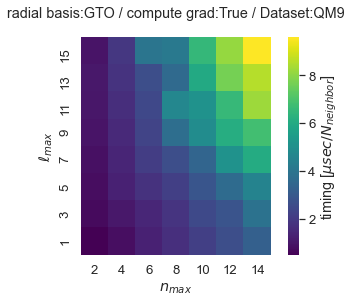

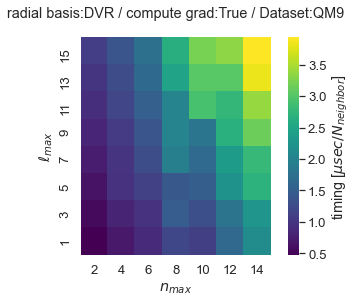

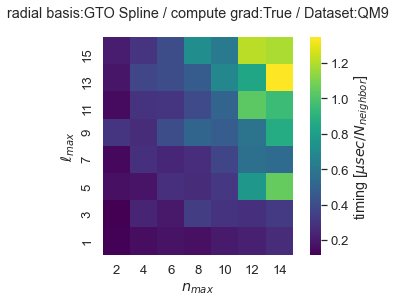

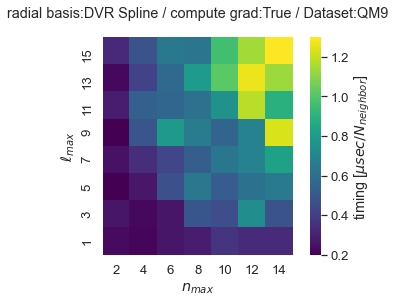

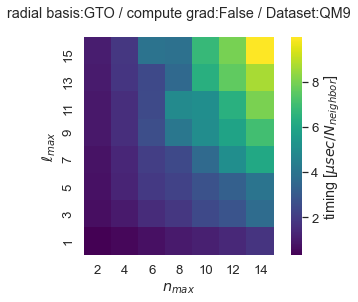

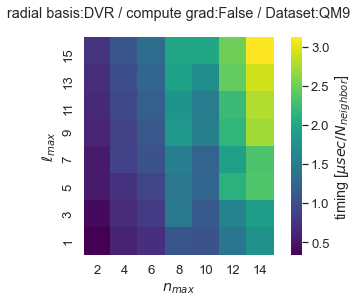

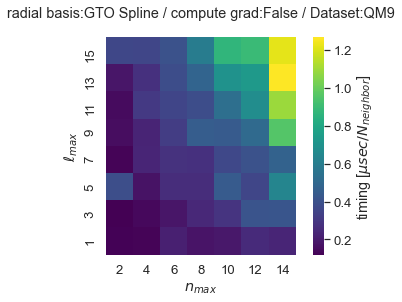

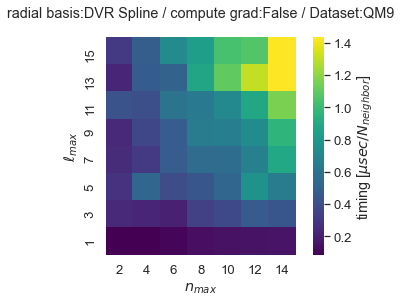

In [198]:
for df in dfs[label]:
    ax = format_contour(df,'$n_{max}$','$\ell_{max}$', 'timing [$\mu sec/N_{neighbor}$]', 
                               ['radial basis','compute grad','Dataset'])
    plt.show()




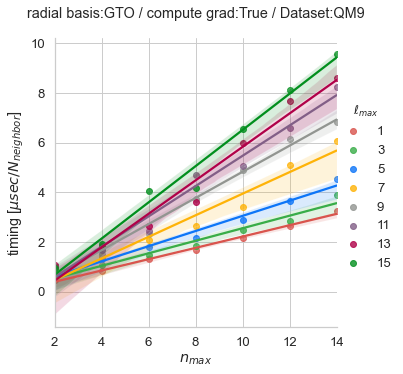

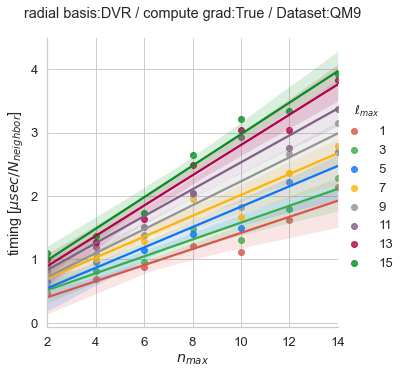

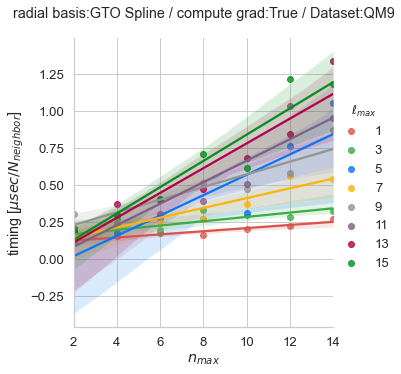

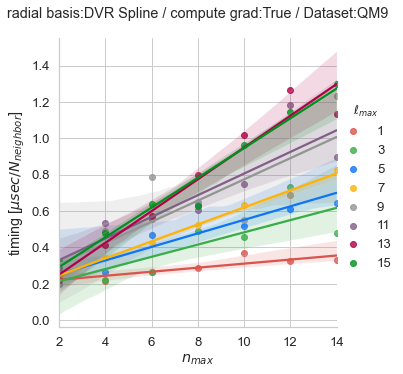

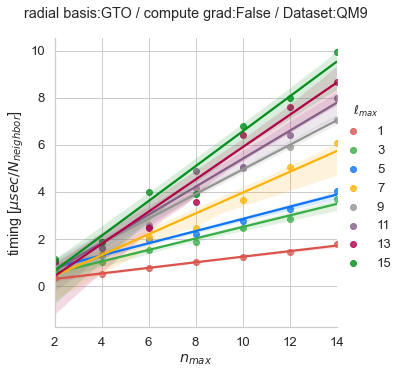

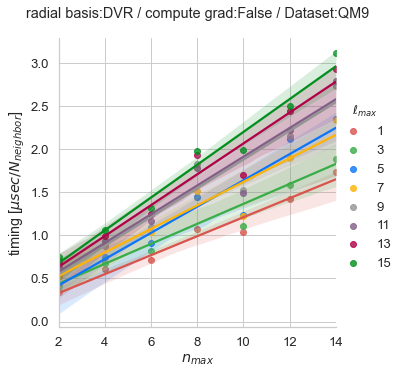

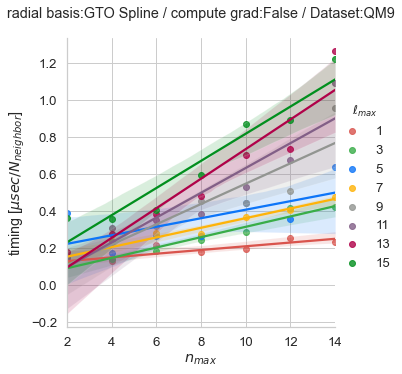

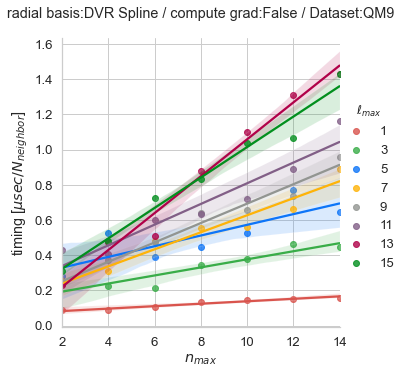

In [167]:
title_values = ['radial basis','compute grad','Dataset']
for df in dfs[label]:
    sns.lmplot(x='$n_{max}$', hue='$\ell_{max}$', y='timing [$\mu sec/N_{neighbor}$]',
               height=5, data=df, palette=palette)
    title = ' / '.join([k+':'+str(df.iloc[0][k]) for k in title_values])
    plt.title(title,pad=20)
    plt.show()
    

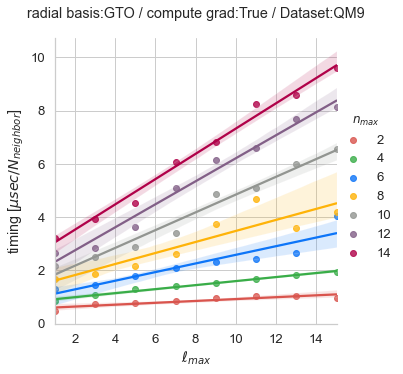

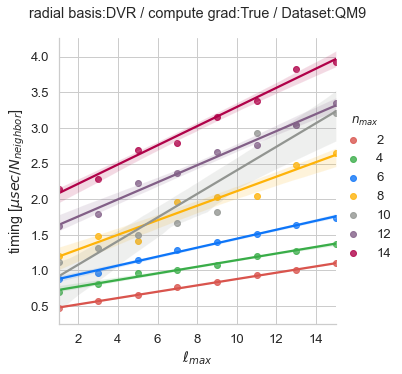

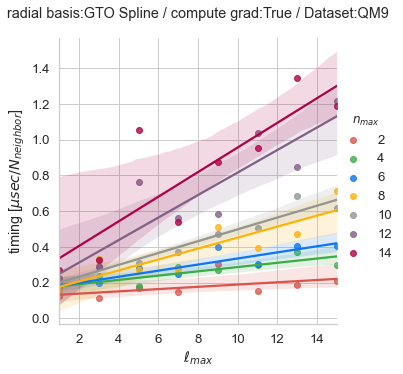

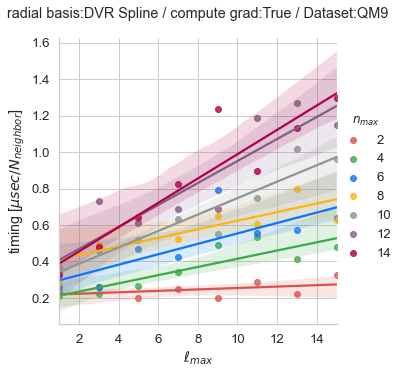

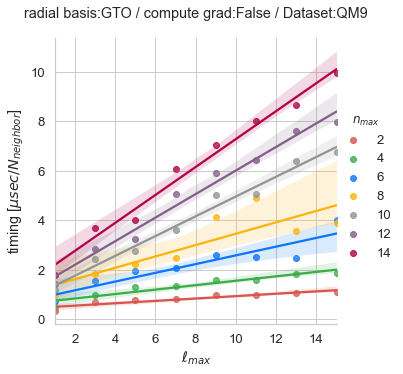

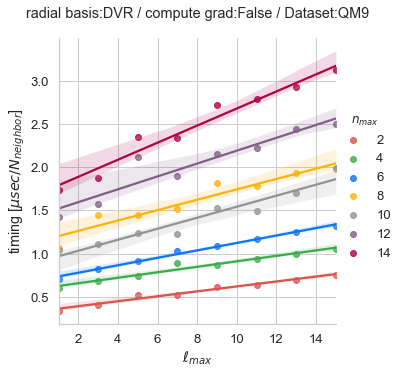

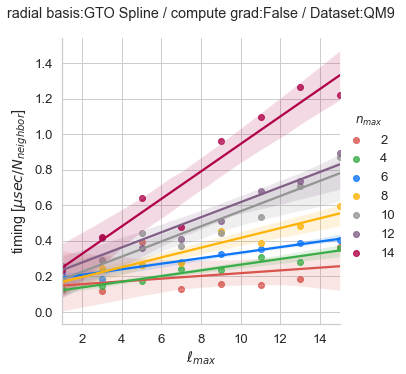

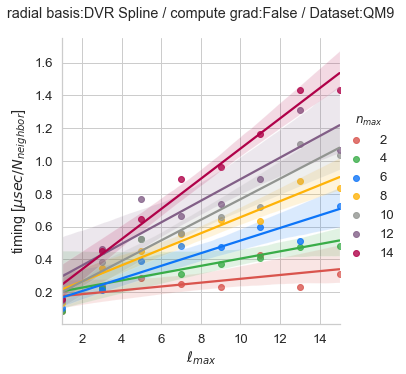

In [168]:
for df in dfs[label]:
    sns.lmplot(hue='$n_{max}$', x='$\ell_{max}$', y='timing [$\mu sec/N_{neighbor}$]',
               height=5, data=df, palette=palette)
    title = ' / '.join([k+':'+str(df.iloc[0][k]) for k in title_values])
    plt.title(title,pad=20)
    plt.show()

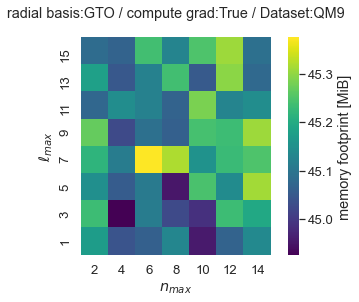

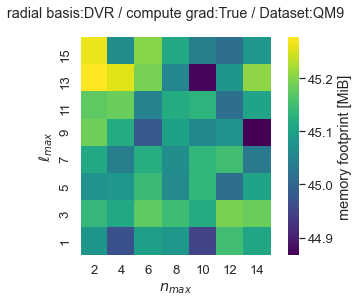

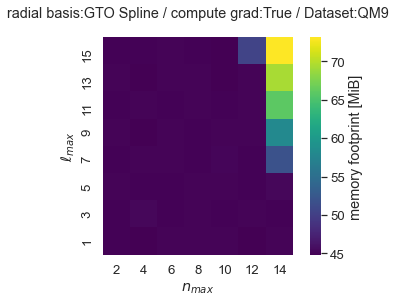

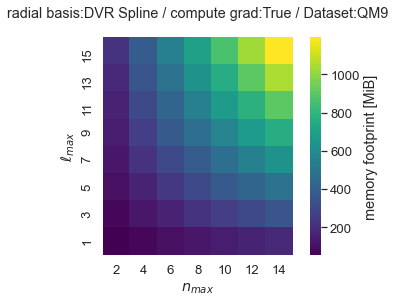

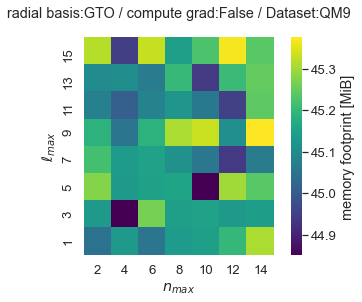

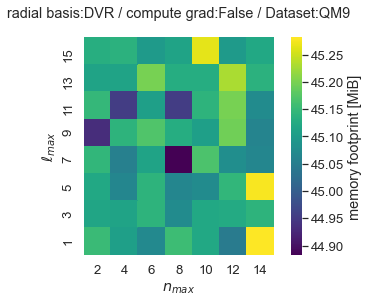

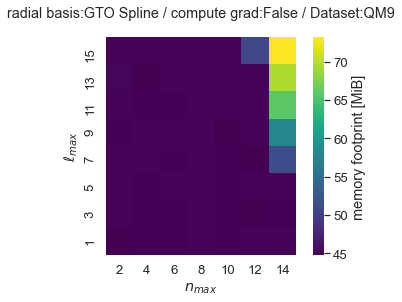

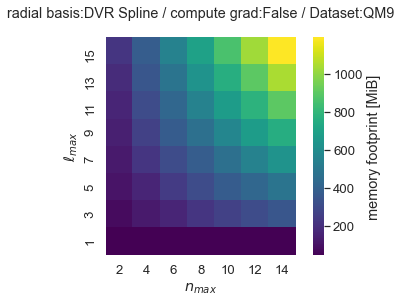

In [144]:
for df in dfs[label]:
    ax = format_contour(df,'$n_{max}$','$\ell_{max}$', 'memory footprint [MiB]', 
                               ['radial basis','compute grad','Dataset'])
    plt.show()

Text(106.08000000000004, 0.5, '$\\ell_{max}$')

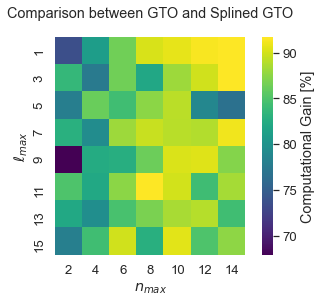

In [184]:
x = '$n_{max}$'
y = '$\ell_{max}$'
z = 'timing [$\mu sec/N_{neighbor}$]'
for data in dfs[label]:
    if data.iloc[0]['radial basis'] == 'GTO' and data.iloc[0]['compute grad'] == True:
        df1 = data.pivot_table(index=y, columns=x, 
                               values=z)
        # df1 = df1.sort_index('index',ascending=False) 
    elif data.iloc[0]['radial basis'] == 'GTO Spline' and data.iloc[0]['compute grad'] == True:
        df2 = data.pivot_table(index=y, columns=x, 
                               values=z)
        # df2 = df2.sort_index('index',ascending=False) 
df = 100*(1-df2 / df1)
ax = sns.heatmap(df,cmap='viridis',square=True, cbar_kws={'label': 'Computational Gain [%]'})
title = 'Comparison between GTO and Splined GTO'
ax.set_title(title,pad=20)
ax.set_xlabel(x)
ax.set_ylabel(y)

Text(106.08000000000004, 0.5, '$\\ell_{max}$')

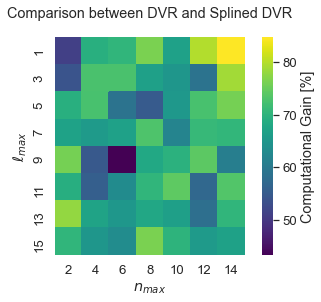

In [185]:
x = '$n_{max}$'
y = '$\ell_{max}$'
z = 'timing [$\mu sec/N_{neighbor}$]'
for data in dfs[label]:
    if data.iloc[0]['radial basis'] == 'DVR' and data.iloc[0]['compute grad'] == True:
        df1 = data.pivot_table(index=y, columns=x, 
                               values=z)
        # df1 = df1.sort_index('index',ascending=False) 
    elif data.iloc[0]['radial basis'] == 'DVR Spline' and data.iloc[0]['compute grad'] == True:
        df2 = data.pivot_table(index=y, columns=x, 
                               values=z)
        # df2 = df2.sort_index('index',ascending=False) 
df = 100*(1-df2 / df1)
ax = sns.heatmap(df,cmap='viridis',square=True, cbar_kws={'label': 'Computational Gain [%]'})
title = 'Comparison between DVR and Splined DVR'
ax.set_title(title,pad=20)
ax.set_xlabel(x)
ax.set_ylabel(y)

Text(106.08000000000004, 0.5, '$\\ell_{max}$')

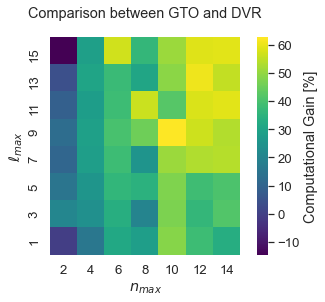

In [238]:
x = '$n_{max}$'
y = '$\ell_{max}$'
z = 'timing [$\mu sec/N_{neighbor}$]'
for data in dfs[label]:
    if data.iloc[0]['radial basis'] == 'GTO' and data.iloc[0]['compute grad'] == True:
        df1 = data.pivot_table(index=y, columns=x, 
                               values=z)
        df1 = df1.sort_index('index',ascending=False) 
    elif data.iloc[0]['radial basis'] == 'DVR' and data.iloc[0]['compute grad'] == True:
        df2 = data.pivot_table(index=y, columns=x, 
                               values=z)
        df2 = df2.sort_index('index',ascending=False) 
df = 100*(1-df2 / df1)
ax = sns.heatmap(df,cmap='viridis',square=True, cbar_kws={'label': 'Computational Gain [%]'})
title = 'Comparison between GTO and DVR'
ax.set_title(title,pad=20)
ax.set_xlabel(x)
ax.set_ylabel(y)

+ increasing n and l increases the computation cost linearly
+ computing the gradient has a marginal cost 
+ GTO is more expensive than DVR for $n_{max}>4$ and/or $l_{max}>4$
+ Spline reduce clearly the cost of GTO and DVR to comparable level
+ Splining increases the memory footprint (something is wierd with the DVR spline)

## Radial integral: Splining accuracy

In [290]:
label = 'Radial integral: Splining accuracy'
queries[label] = []

radial_basis
radial_basis_args = {
    'GTO Spline' : {'representation.optimization_args.type':{'$exists':True},
                    'representation.radial_basis':'GTO'
                   },
    'DVR Spline' : {'representation.optimization_args.type':{'$exists':True},
                    'representation.radial_basis':'DVR'
                   },
}
rc = 4

for fn, rb in product(fns, ['GTO Spline','DVR Spline']):
    qry = { 'fn':fn, 'type':rb,
        'query':{
            'filename':fn,
            'representation.compute_gradients':{'$eq':True},
            'representation.interaction_cutoff': {'$eq':rc}
        }
    }
    qry['query'].update(**radial_basis_args[rb])
    queries[label].append(qry)

dfs[label] = []
project = signac.get_project(fn_projects['ri'])
for qry in queries[label]:
    results = []
    for job in project.find_jobs(qry['query']):
        res = {
            '$\ell_{max}$':job.sp.representation.max_angular, 
            '$n_{max}$':job.sp.representation.max_radial,
            '$\ell_{max}$ / $n_{max}$': '{} / {}'.format(job.sp.representation.max_angular,
                                                         job.sp.representation.max_radial),
            'accuracy':job.sp.representation.optimization_args.accuracy,
            'radial basis':qry['type'], 
            'Dataset': fns2name[qry['fn']], 
            '$\sigma$': job.sp.representation.gaussian_sigma_constant
        }
        res.update(**job.document)
        res['timing [$\mu sec/N_{neighbor}$]'] = 1e6 * res['elapsed_mean'] / res['n_neighbors']
        res['memory footprint [MiB]'] = res['mem_max']
        results.append(res)
    dfs[label].append(pd.DataFrame(results))

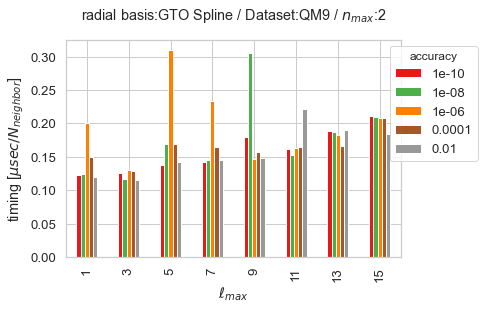

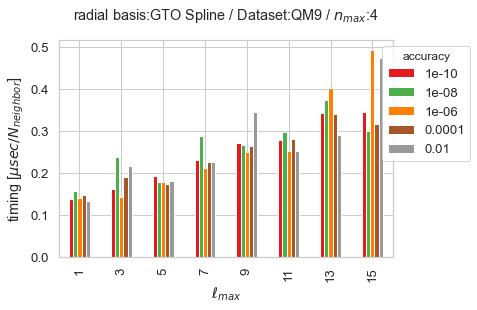

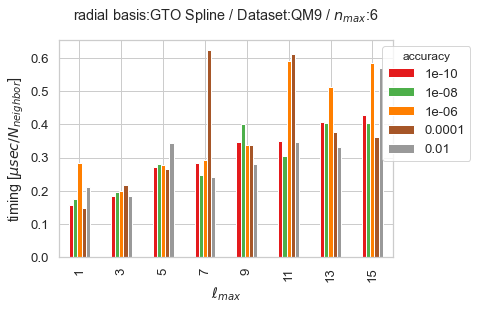

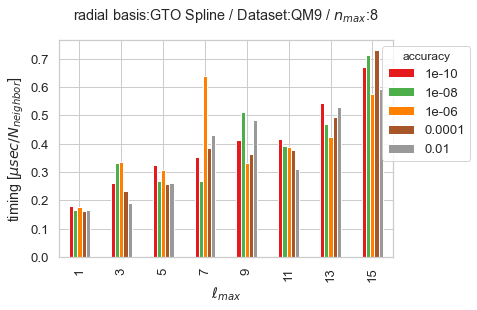

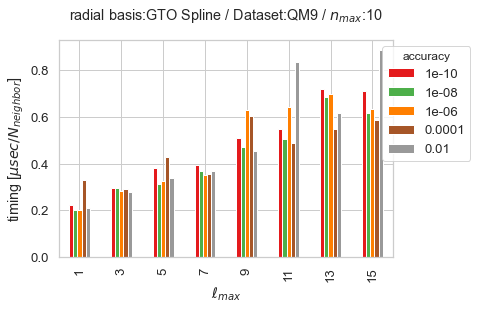

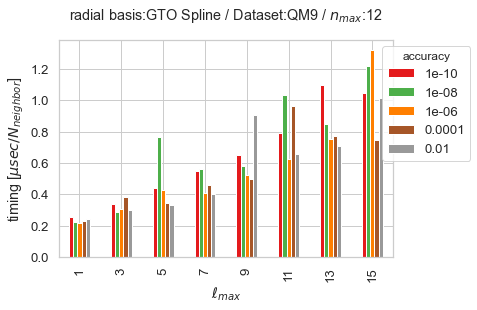

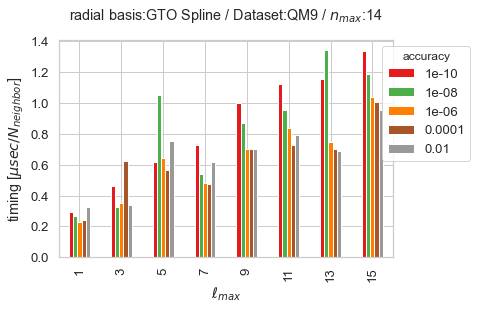

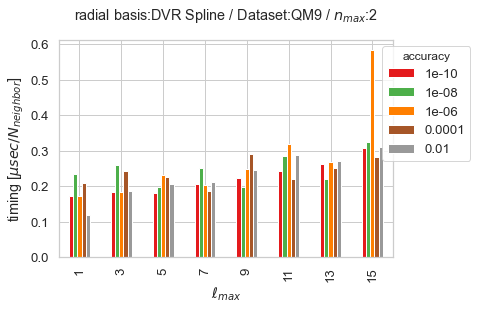

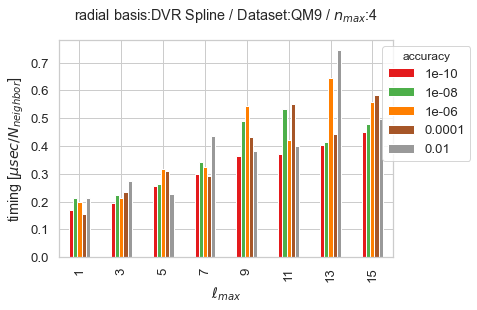

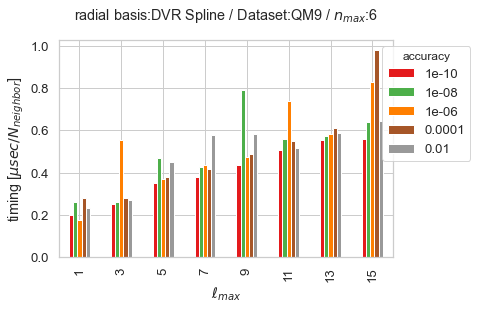

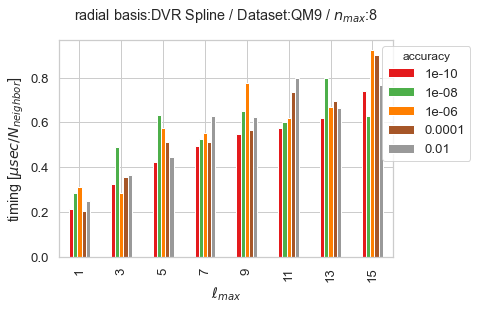

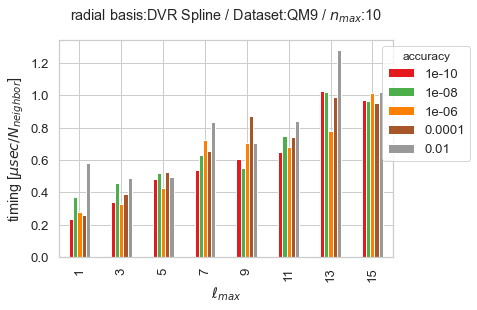

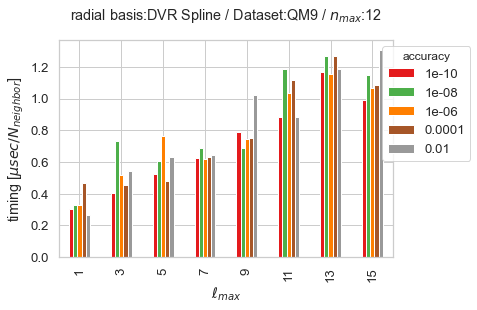

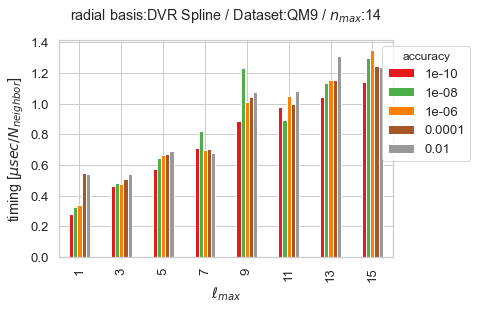

In [292]:
title_values = ['radial basis', 'Dataset', '$n_{max}$']
for df in dfs[label]:
    nu = np.unique(df['$n_{max}$'])
    for n in nu:
        df1 = df[df['$n_{max}$'] == n]
        df2 = df1.pivot_table(columns='accuracy', index='$\ell_{max}$', values='timing [$\mu sec/N_{neighbor}$]')

        df2.plot(kind='bar', stacked=False, colormap="Set1")
        title = ' / '.join([k+':'+str(df1.iloc[0][k]) for k in title_values])
        plt.title(title,pad=20)
        plt.ylabel('timing [$\mu sec/N_{neighbor}$]')
        plt.legend(title='accuracy',loc='upper right', bbox_to_anchor=(1.25, 1))
        plt.show()

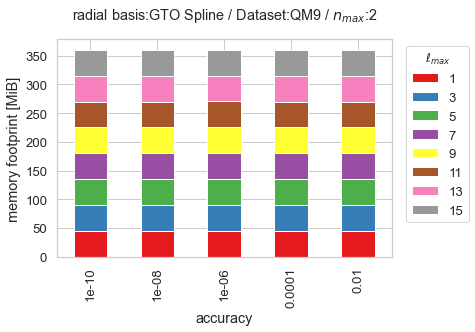

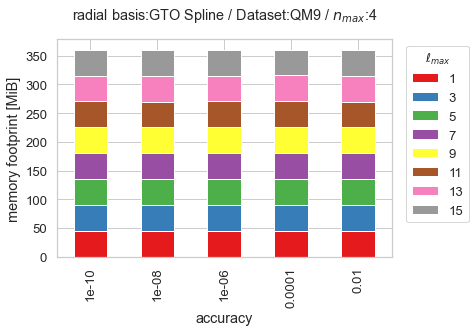

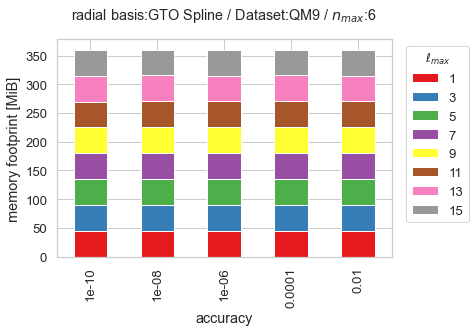

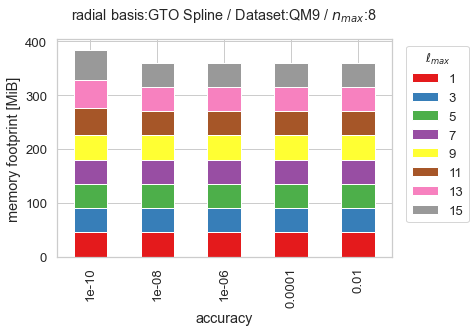

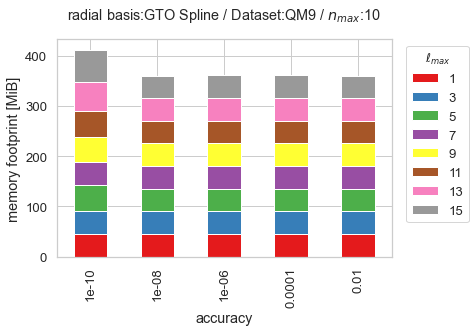

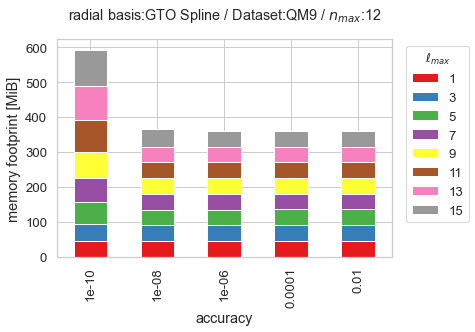

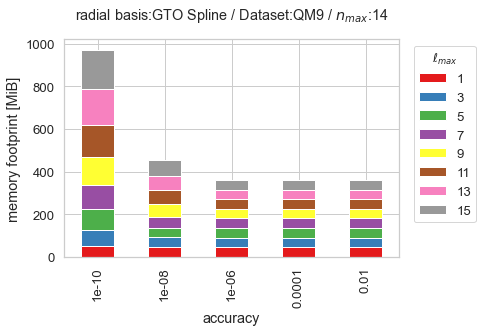

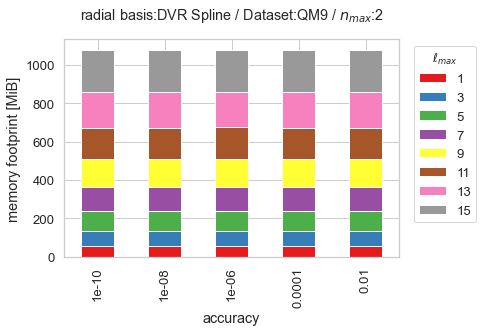

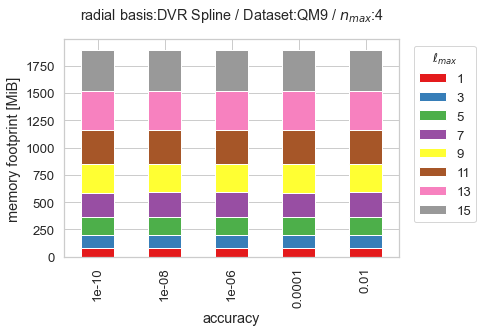

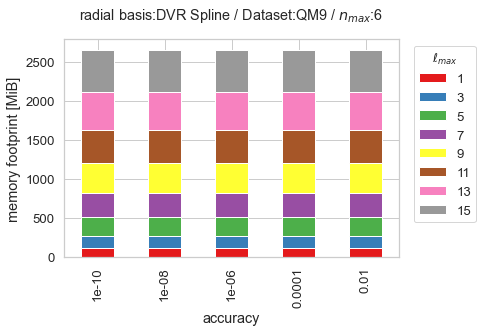

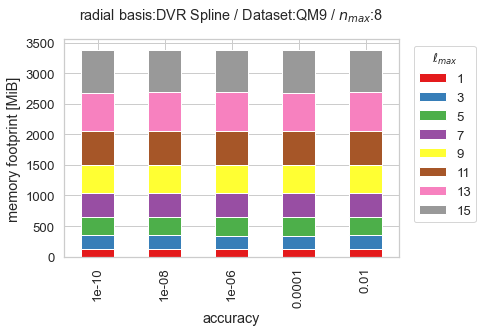

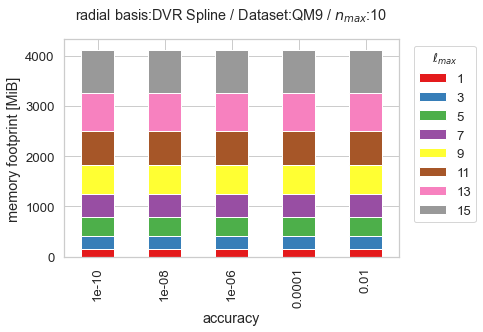

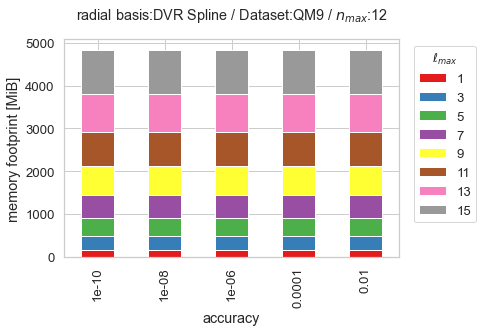

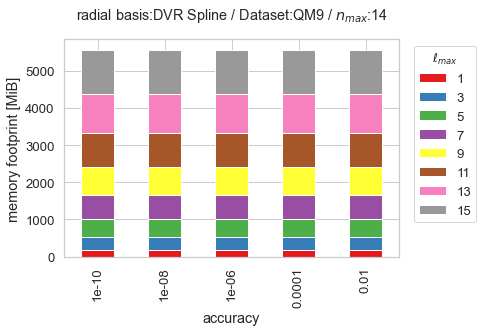

In [234]:
title_values = ['radial basis', 'Dataset', '$n_{max}$']
for df in dfs[label]:
    nu = np.unique(df['$n_{max}$'])
    for n in nu:
        df1 = df[df['$n_{max}$'] == n]
        df2 = df1.pivot_table(columns='$\ell_{max}$', index='accuracy', values='memory footprint [MiB]')

        df2.plot(kind='bar', stacked=True, colormap="Set1")
        title = ' / '.join([k+':'+str(df1.iloc[0][k]) for k in title_values])
        plt.title(title,pad=20)
        plt.ylabel('memory footprint [MiB]')
        plt.legend(title='$\ell_{max}$',loc='upper right', bbox_to_anchor=(1.25, 1))
        plt.show()

+ splined ri timing does not depend on the accuracy
+ memory footprint does not change much with accuracy

# spherical harmonics

In [240]:
project = signac.get_project(fn_projects['sph'])
for job in project.find_jobs():
    print(job.sp)

{'filename': '../../structures/qm9.json', 'representation': {'interaction_cutoff': 3, 'cutoff_smooth_width': 0.5, 'max_radial': 2, 'max_angular': 15, 'gaussian_sigma_type': 'Constant', 'compute_gradients': False}, 'N_ITERATIONS': 20, 'n_structures': 500}
{'filename': '../../structures/qm9.json', 'representation': {'interaction_cutoff': 3, 'cutoff_smooth_width': 0.5, 'max_radial': 2, 'max_angular': 3, 'gaussian_sigma_type': 'Constant', 'compute_gradients': False}, 'N_ITERATIONS': 20, 'n_structures': 500}
{'filename': '../../structures/qm9.json', 'representation': {'interaction_cutoff': 3, 'cutoff_smooth_width': 0.5, 'max_radial': 2, 'max_angular': 13, 'gaussian_sigma_type': 'Constant', 'compute_gradients': False}, 'N_ITERATIONS': 20, 'n_structures': 500}
{'filename': '../../structures/qm9.json', 'representation': {'interaction_cutoff': 2, 'cutoff_smooth_width': 0.5, 'max_radial': 2, 'max_angular': 9, 'gaussian_sigma_type': 'Constant', 'compute_gradients': False}, 'N_ITERATIONS': 20, 'n_

## spherical harmonics $l_{max}$

In [244]:
label = 'spherical harmonics $l_{max}$'
queries[label] = []

rc = 4
for fn, grad in product(fns, grads):
    qry = { 'fn':fn, 'grad':grad, 
        'query':{
            'filename':fn,
            'representation.compute_gradients':grad,
            # 'representation.interaction_cutoff': {'$eq':rc}
        }
    }
    queries[label].append(qry)

dfs[label] = []
project = signac.get_project(fn_projects['sph'])
for qry in queries[label]:
    results = []
    for job in project.find_jobs(qry['query']):
        res = {
            '$\ell_{max}$':job.sp.representation.max_angular, 
            '$r_{c}$':job.sp.representation.interaction_cutoff,
            'compute grad':qry['grad'],
            'Dataset': fns2name[qry['fn']], 
        }
        res.update(**job.document)
        res['timing [$\mu sec/N_{neighbor}$]'] = 1e6 * res['elapsed_mean'] / res['n_neighbors']
        res['memory footprint [MiB]'] = res['mem_max']
        results.append(res)
    dfs[label].append(pd.DataFrame(results))

In [256]:
df2.plot?

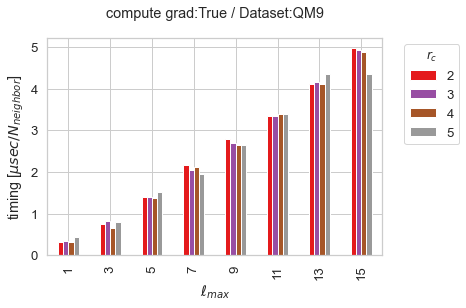

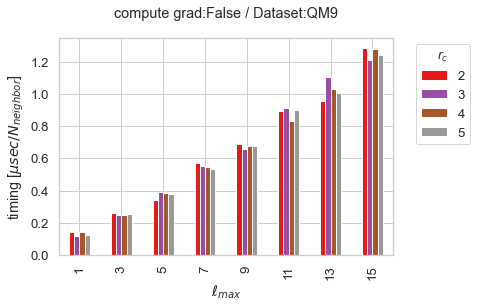

In [260]:
title_values = ['compute grad', 'Dataset']
for df in dfs[label]:
    df2 = df.pivot_table(index='$\ell_{max}$', columns='$r_{c}$', values='timing [$\mu sec/N_{neighbor}$]')
    df2.plot(kind='bar', stacked=False, colormap="Set1")
    title = ' / '.join([k+':'+str(df.iloc[0][k]) for k in title_values])
    plt.title(title,pad=20)
    plt.ylabel('timing [$\mu sec/N_{neighbor}$]')
    plt.legend(title='$r_{c}$',loc='upper right', bbox_to_anchor=(1.25, 1))
    plt.show()

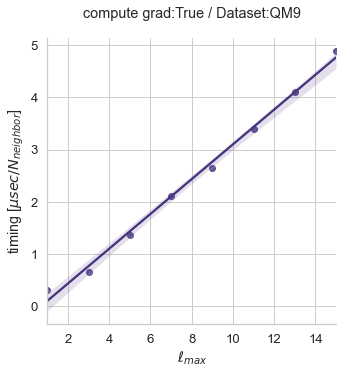

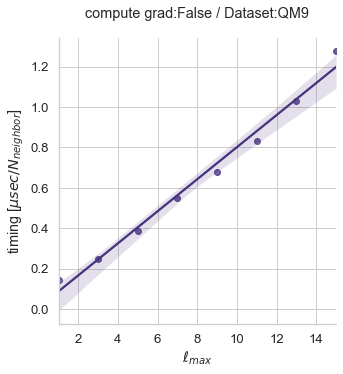

In [250]:
for df in dfs[label]:
    df1 = df[df['$r_{c}$']==rc]
    sns.lmplot(x='$\ell_{max}$', y='timing [$\mu sec/N_{neighbor}$]',
               height=5, data=df1, palette=palette, fit_reg=True)
    title = ' / '.join([k+':'+str(df.iloc[0][k]) for k in title_values])
    plt.title(title,pad=20)
    plt.show()

+ runs with differtent $r_c$ have the same runtime
+ Computing with gradients is 4 times more expansive
+ increasing $\ell_{max}$ increases linearly the cost

# spherical expansion

In [ ]:
def format_contour(data,x,y,z,title_values):
    df = data.pivot_table(index=y, columns=x, values=z)
    df = df.sort_index('index',ascending=False) 
    ax = sns.heatmap(df,cmap='viridis',square=True, cbar_kws={'label': z})
    title = ' / '.join([k+':'+str(data.iloc[0][k]) for k in title_values])
    ax.set_title(title,pad=20)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    return ax

## spherical expansion $n_{max}\;vs\;l_{max}$

In [293]:
label = 'spherical expansion $n_{max}\;vs\;l_{max}$'
queries[label] = []

rc = 4
accuracy = 1e-8
radial_basis_args = {
    'GTO' : {'representation.optimization_args.type':{'$exists':False},
             'representation.radial_basis':'GTO'},
    'DVR' : {'representation.optimization_args.type':{'$exists':False},
             'representation.radial_basis':'DVR'},
    'GTO Spline' : {'representation.optimization_args.type':{'$exists':True},
                    # 'representation.optimization_args.accuracy': {'$eq':accuracy},
                    'representation.radial_basis':'GTO'
                   },
    'DVR Spline' : {'representation.optimization_args.type':{'$exists':True},
                    # 'representation.optimization_args.accuracy': {'$eq':accuracy},
                    'representation.radial_basis':'DVR'
                   },
}


for fn, grad, rb in product(fns, grads, radial_basis):
    qry = { 'fn':fn, 'grad':grad, 'type':rb,
        'query':{
            'filename':fn,
            'representation.compute_gradients':grad,
            'representation.interaction_cutoff': {'$eq':rc}
        }
    }
    qry['query'].update(**radial_basis_args[rb])
    queries[label].append(qry)

dfs[label] = []
project = signac.get_project(fn_projects['se'])
for qry in queries[label]:
    results = []
    for job in project.find_jobs(qry['query']):
        res = {
            '$\ell_{max}$':job.sp.representation.max_angular, 
            '$n_{max}$':job.sp.representation.max_radial,
            'radial basis':qry['type'], 
            'compute grad':qry['grad'],
            'Dataset': fns2name[qry['fn']], 
            '$\sigma$': job.sp.representation.gaussian_sigma_constant
        }
        res.update(**job.document)
        res['timing [$\mu sec/N_{neighbor}$]'] = 1e6 * res['elapsed_mean'] / res['n_neighbors']
        res['memory footprint [MiB]'] = res['mem_max']
        results.append(res)
    dfs[label].append(pd.DataFrame(results))

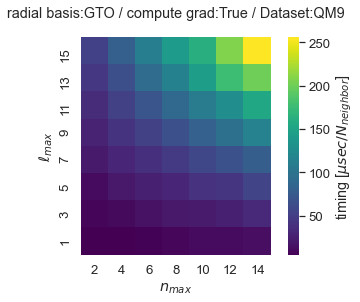

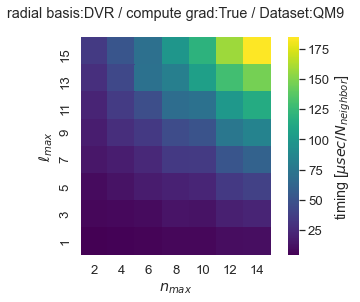

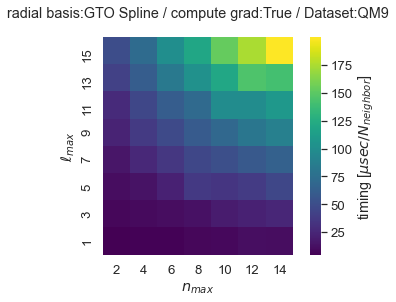

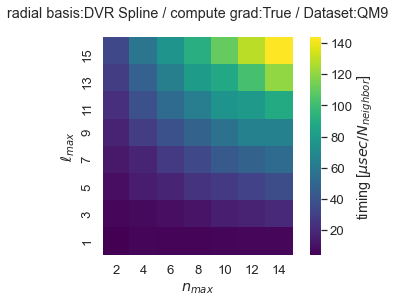

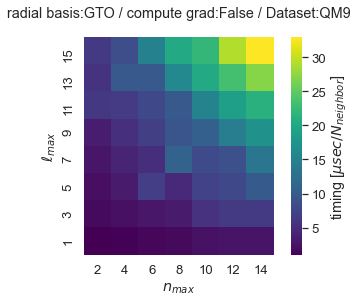

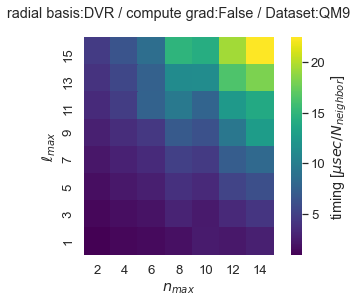

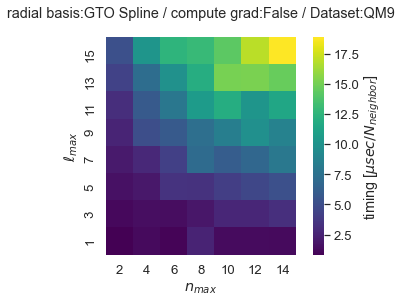

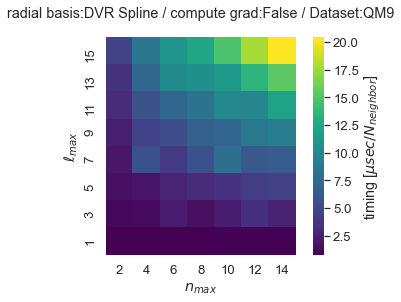

In [294]:
for df in dfs[label]:
    ax = format_contour(df,'$n_{max}$','$\ell_{max}$', 'timing [$\mu sec/N_{neighbor}$]', 
                               ['radial basis','compute grad','Dataset'])
    plt.show()




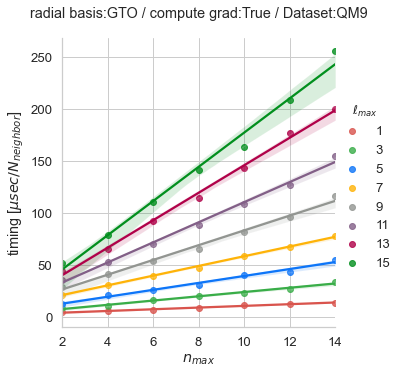

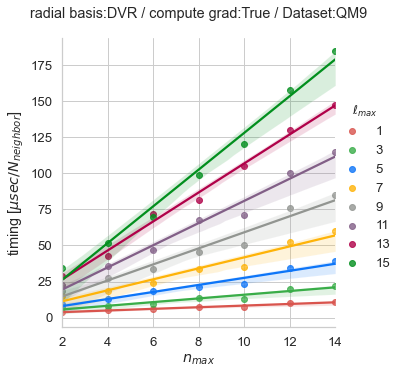

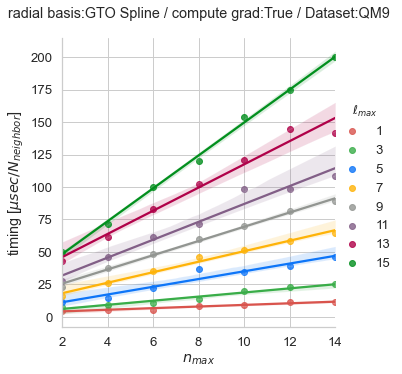

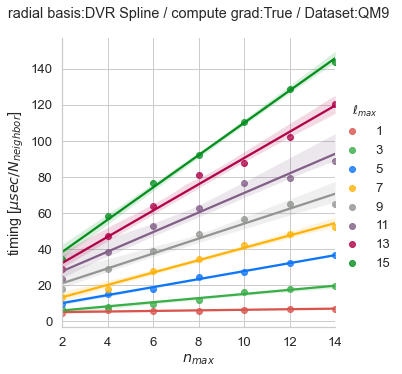

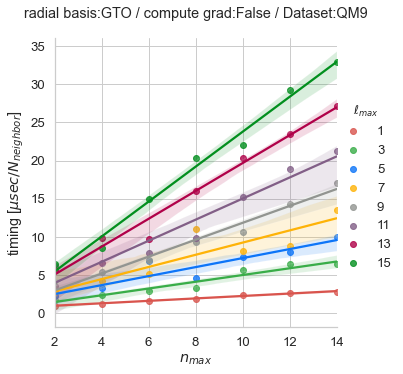

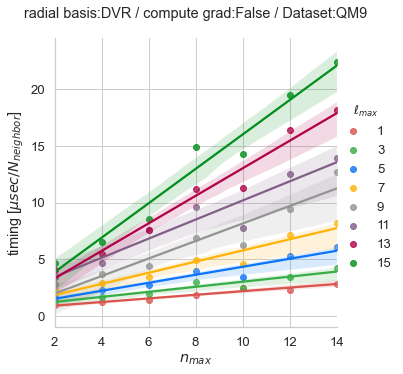

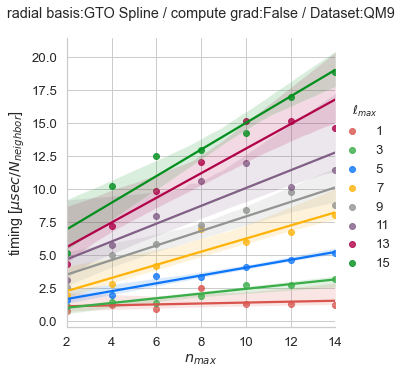

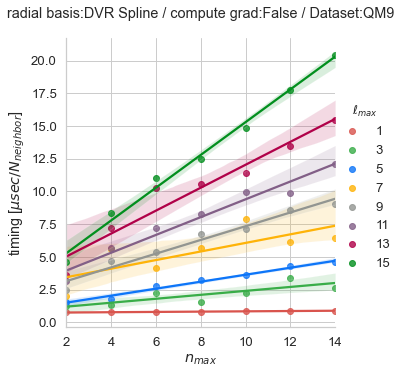

In [269]:
title_values = ['radial basis','compute grad','Dataset']
for df in dfs[label]:
    sns.lmplot(x='$n_{max}$', hue='$\ell_{max}$', y='timing [$\mu sec/N_{neighbor}$]',
               height=5, data=df, palette=palette)
    title = ' / '.join([k+':'+str(df.iloc[0][k]) for k in title_values])
    plt.title(title,pad=20)
    plt.show()
    

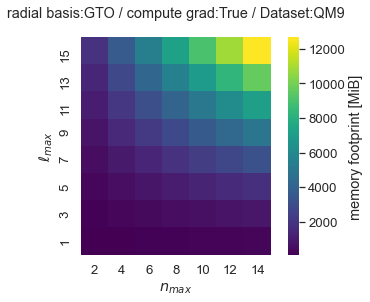

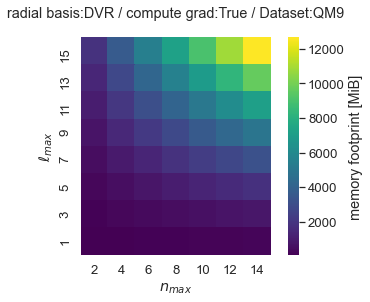

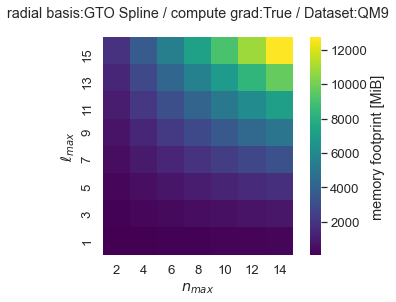

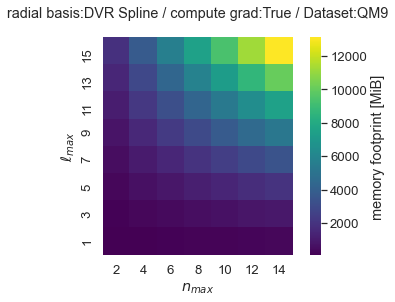

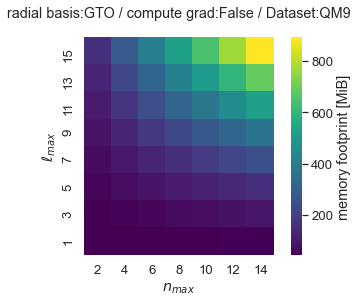

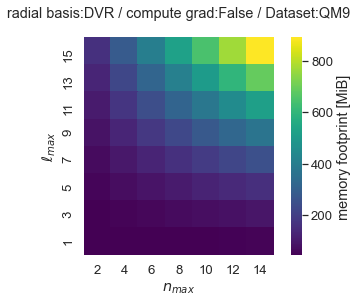

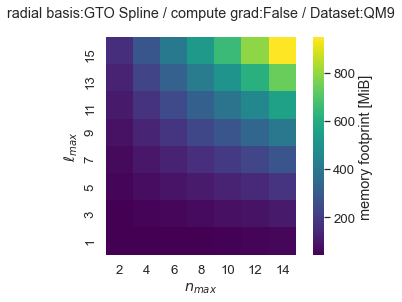

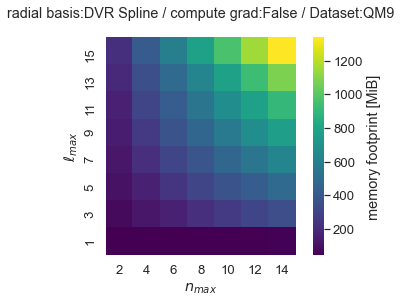

In [270]:
for df in dfs[label]:
    ax = format_contour(df,'$n_{max}$','$\ell_{max}$', 'memory footprint [MiB]', 
                               ['radial basis','compute grad','Dataset'])
    plt.show()

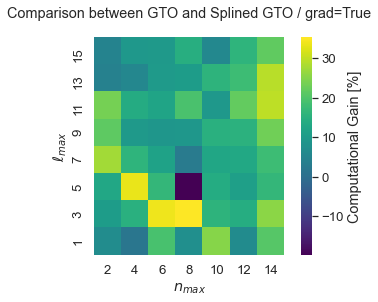

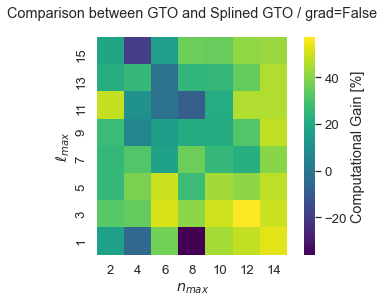

In [274]:
x = '$n_{max}$'
y = '$\ell_{max}$'
z = 'timing [$\mu sec/N_{neighbor}$]'
for data in dfs[label]:
    if data.iloc[0]['radial basis'] == 'GTO' and data.iloc[0]['compute grad'] == True:
        df1 = data.pivot_table(index=y, columns=x, 
                               values=z)
        df1 = df1.sort_index('index',ascending=False) 
    elif data.iloc[0]['radial basis'] == 'GTO Spline' and data.iloc[0]['compute grad'] == True:
        df2 = data.pivot_table(index=y, columns=x, 
                               values=z)
        df2 = df2.sort_index('index',ascending=False)
    if data.iloc[0]['radial basis'] == 'GTO' and data.iloc[0]['compute grad'] == False:
        df3 = data.pivot_table(index=y, columns=x, 
                               values=z)
        df3 = df3.sort_index('index',ascending=False) 
    elif data.iloc[0]['radial basis'] == 'GTO Spline' and data.iloc[0]['compute grad'] == False:
        df4 = data.pivot_table(index=y, columns=x, 
                               values=z)
        df4 = df4.sort_index('index',ascending=False) 
        
df = 100*(1-df2 / df1)
ax = sns.heatmap(df,cmap='viridis',square=True, cbar_kws={'label': 'Computational Gain [%]'})
title = 'Comparison between GTO and Splined GTO / grad=True'
ax.set_title(title,pad=20)
ax.set_xlabel(x)
ax.set_ylabel(y)
plt.show()

df = 100*(1-df4 / df3)
ax = sns.heatmap(df,cmap='viridis',square=True, cbar_kws={'label': 'Computational Gain [%]'})
title = 'Comparison between GTO and Splined GTO / grad=False'
ax.set_title(title,pad=20)
ax.set_xlabel(x)
ax.set_ylabel(y)
plt.show()

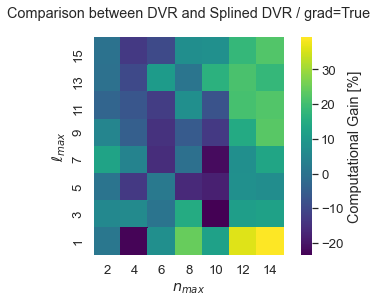

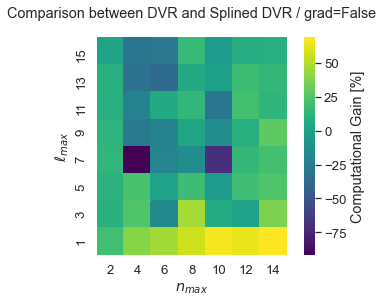

In [275]:
x = '$n_{max}$'
y = '$\ell_{max}$'
z = 'timing [$\mu sec/N_{neighbor}$]'
for data in dfs[label]:
    if data.iloc[0]['radial basis'] == 'DVR' and data.iloc[0]['compute grad'] == True:
        df1 = data.pivot_table(index=y, columns=x, 
                               values=z)
        df1 = df1.sort_index('index',ascending=False) 
    elif data.iloc[0]['radial basis'] == 'DVR Spline' and data.iloc[0]['compute grad'] == True:
        df2 = data.pivot_table(index=y, columns=x, 
                               values=z)
        df2 = df2.sort_index('index',ascending=False) 
    if data.iloc[0]['radial basis'] == 'DVR' and data.iloc[0]['compute grad'] == False:
        df3 = data.pivot_table(index=y, columns=x, 
                               values=z)
        df3 = df3.sort_index('index',ascending=False) 
    elif data.iloc[0]['radial basis'] == 'DVR Spline' and data.iloc[0]['compute grad'] == False:
        df4 = data.pivot_table(index=y, columns=x, 
                               values=z)
        df4 = df4.sort_index('index',ascending=False) 
df = 100*(1-df2 / df1)
ax = sns.heatmap(df,cmap='viridis',square=True, cbar_kws={'label': 'Computational Gain [%]'})
title = 'Comparison between DVR and Splined DVR / grad=True'
ax.set_title(title,pad=20)
ax.set_xlabel(x)
ax.set_ylabel(y)
plt.show()

df = 100*(1-df4 / df3)
ax = sns.heatmap(df,cmap='viridis',square=True, cbar_kws={'label': 'Computational Gain [%]'})
title = 'Comparison between DVR and Splined DVR / grad=False'
ax.set_title(title,pad=20)
ax.set_xlabel(x)
ax.set_ylabel(y)
plt.show()

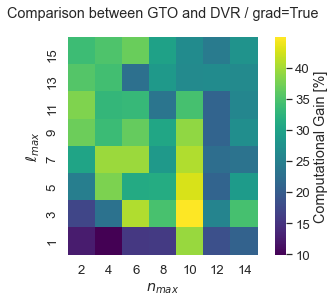

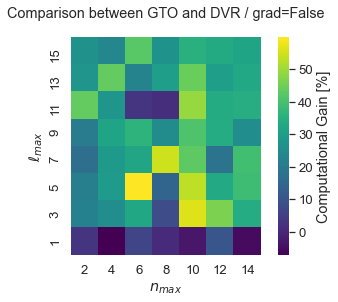

In [276]:
x = '$n_{max}$'
y = '$\ell_{max}$'
z = 'timing [$\mu sec/N_{neighbor}$]'
for data in dfs[label]:
    if data.iloc[0]['radial basis'] == 'GTO' and data.iloc[0]['compute grad'] == True:
        df1 = data.pivot_table(index=y, columns=x, 
                               values=z)
        df1 = df1.sort_index('index',ascending=False) 
    elif data.iloc[0]['radial basis'] == 'DVR' and data.iloc[0]['compute grad'] == True:
        df2 = data.pivot_table(index=y, columns=x, 
                               values=z)
        df2 = df2.sort_index('index',ascending=False) 
    if data.iloc[0]['radial basis'] == 'GTO' and data.iloc[0]['compute grad'] == False:
        df3 = data.pivot_table(index=y, columns=x, 
                               values=z)
        df3 = df3.sort_index('index',ascending=False) 
    elif data.iloc[0]['radial basis'] == 'DVR' and data.iloc[0]['compute grad'] == False:
        df4 = data.pivot_table(index=y, columns=x, 
                               values=z)
        df4 = df4.sort_index('index',ascending=False) 

df = 100*(1-df2 / df1)
ax = sns.heatmap(df,cmap='viridis',square=True, cbar_kws={'label': 'Computational Gain [%]'})
title = 'Comparison between GTO and DVR / grad=True'
ax.set_title(title,pad=20)
ax.set_xlabel(x)
ax.set_ylabel(y)
plt.show()

df = 100*(1-df4 / df3)
ax = sns.heatmap(df,cmap='viridis',square=True, cbar_kws={'label': 'Computational Gain [%]'})
title = 'Comparison between GTO and DVR / grad=False'
ax.set_title(title,pad=20)
ax.set_xlabel(x)
ax.set_ylabel(y)
plt.show()

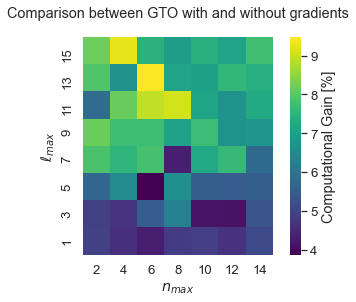

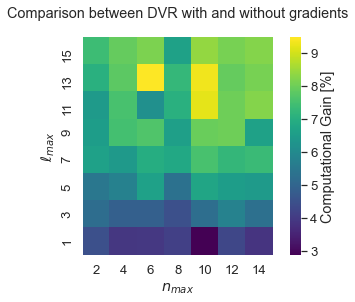

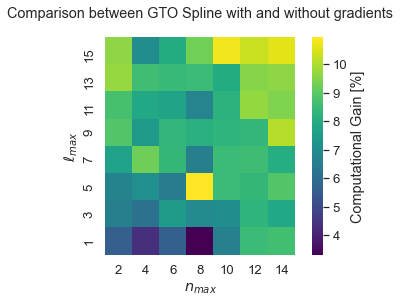

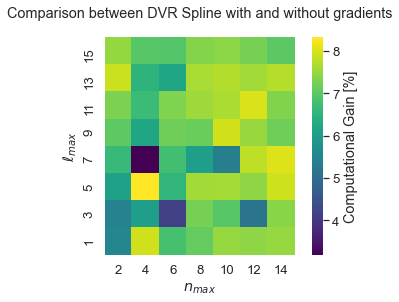

In [297]:
x = '$n_{max}$'
y = '$\ell_{max}$'
z = 'timing [$\mu sec/N_{neighbor}$]'
for rb in radial_basis:
    for data in dfs[label]:
        if data.iloc[0]['radial basis'] == rb and data.iloc[0]['compute grad'] == True:
            df1 = data.pivot_table(index=y, columns=x, 
                                   values=z)
            df1 = df1.sort_index('index',ascending=False) 
        elif data.iloc[0]['radial basis'] == rb and data.iloc[0]['compute grad'] == False:
            df2 = data.pivot_table(index=y, columns=x, 
                                   values=z)
            df2 = df2.sort_index('index',ascending=False) 
    # df = 100*(1-df2 / df1)
    df = (df1 / df2)
    ax = sns.heatmap(df,cmap='viridis',square=True, cbar_kws={'label': 'Computational Gain [%]'})
    title = 'Comparison between {} with and without gradients'.format(rb)
    ax.set_title(title,pad=20)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    plt.show()

# Spherical Invariants

In [25]:
def fromjson(fn):
    with open(fn, 'r') as f:
        data = json.load(f)
    return data

In [11]:
project = signac.get_project(fn_projects['si'])
ii =0 
for job in project.find_jobs():
    if 'elapsed_mean' in job.document:
        if job.document.elapsed_mean < 3*job.document.elapsed_std:
            # print(job.sp.name,job.sp.representation.compute_gradients, job.sp.representation.optimization_args , job.sp.representation.radial_basis, job.document.elapsed_mean ,job.document.elapsed_std)
            
            # data = fromjson(job.fn('in_ri_cpp.json'))
            print(job.sp.name, job.sp.representation.radial_basis, job.sp.representation.optimization_args,job.document.elapsed_mean ,job.document.elapsed_std)
            ii += 1

molecular_crystals DVR {} 0.6290221492 0.2425363359565798
molecular_crystals GTO {'type': 'Spline', 'accuracy': 1e-08, 'range': [0, 4]} 7.314798756 3.0668843790014115
methane_sulfonic DVR {'type': 'Spline', 'accuracy': 1e-08, 'range': [0, 4]} 0.5928525952 0.2214271907169797
silicon_bulk DVR {'type': 'Spline', 'accuracy': 1e-08, 'range': [0, 4]} 0.5166984156 0.20619169473801516
molecular_crystals GTO {'type': 'Spline', 'accuracy': 1e-08, 'range': [0, 4]} 1.1032780248 0.3751495167280558
silicon_bulk DVR {} 6.3313651588 2.123988412297819
molecular_crystals GTO {'type': 'Spline', 'accuracy': 1e-08, 'range': [0, 4]} 21.2220880152 7.306560634269742
qm9 GTO {'type': 'Spline', 'accuracy': 1e-08, 'range': [0, 4]} 1.5073684604 0.510497946015457
molecular_crystals GTO {'type': 'Spline', 'accuracy': 1e-08, 'range': [0, 4]} 0.9902451767999999 0.41469300826866795
qm9 DVR {'type': 'Spline', 'accuracy': 1e-08, 'range': [0, 4]} 3.1152339650000003 1.0613635419499252
methane_sulfonic GTO {'type': 'Spline

silicon_bulk DVR {} 3.2436000586 1.2853230024486346
methane_liquid DVR {} 1.0665416252 0.3999573404231602
methane_sulfonic GTO {'type': 'Spline', 'accuracy': 1e-08, 'range': [0, 4]} 15.625678316599998 5.25235348247493
qm9 GTO {'type': 'Spline', 'accuracy': 1e-08, 'range': [0, 4]} 1.4136812392000002 0.48137525344079823
methane_liquid GTO {} 0.5334737371999999 0.20535933786259286
methane_sulfonic GTO {} 2.24324382 0.7803131009329438
silicon_bulk GTO {'type': 'Spline', 'accuracy': 1e-08, 'range': [0, 4]} 0.9528074674000001 0.3914721461652237
methane_sulfonic GTO {'type': 'Spline', 'accuracy': 1e-08, 'range': [0, 4]} 0.9627496938 0.3382962466443547
qm9 DVR {} 2.2134604218 0.8940529119949226
qm9 DVR {} 0.461965071 0.16057156293348168
methane_sulfonic GTO {} 2.0575102781999997 0.6933901631515568
qm9 GTO {'type': 'Spline', 'accuracy': 1e-08, 'range': [0, 4]} 3.4684891652000003 1.3653048011969593
molecular_crystals GTO {'type': 'Spline', 'accuracy': 1e-08, 'range': [0, 4]} 1.3818650533999999 0

qm9 GTO {} 0.40652533039999994 0.1779597180524913
methane_liquid DVR {} 3.616748446 1.4918402240597792
methane_sulfonic DVR {} 6.1866084818000004 2.4371178201794086
silicon_bulk GTO {} 2.2920332366 0.8114759850828583
silicon_bulk GTO {} 0.28559730660000004 0.13612952010558127
methane_liquid GTO {'type': 'Spline', 'accuracy': 1e-08, 'range': [0, 4]} 6.3209153118 2.110876459979553
methane_sulfonic DVR {'type': 'Spline', 'accuracy': 1e-08, 'range': [0, 4]} 0.6932297378 0.26268834406389374
methane_sulfonic DVR {} 0.6958095093999999 0.26068035025861735
silicon_bulk DVR {} 3.2152222252000002 1.1202290622384807
molecular_crystals DVR {} 5.598583776 2.465001463744092
methane_sulfonic DVR {} 6.678275075799999 2.235816377911056
methane_sulfonic GTO {'type': 'Spline', 'accuracy': 1e-08, 'range': [0, 4]} 1.5712771566000001 0.5381476608151958
molecular_crystals DVR {} 0.26440361879999996 0.08886789055123974
molecular_crystals DVR {'type': 'Spline', 'accuracy': 1e-08, 'range': [0, 4]} 7.6059728562 2

qm9 GTO {'type': 'Spline', 'accuracy': 1e-08, 'range': [0, 4]} 25.625003483199997 9.270239581515092
methane_sulfonic GTO {} 1.4573190832 0.7139116706411329
methane_sulfonic GTO {} 0.5115549554000001 0.1829043266192095
qm9 DVR {} 10.136827360400002 3.6977977361187815
silicon_bulk GTO {'type': 'Spline', 'accuracy': 1e-08, 'range': [0, 4]} 5.2713377092 2.0678555219922274
silicon_bulk GTO {'type': 'Spline', 'accuracy': 1e-08, 'range': [0, 4]} 1.0825841541999999 0.45087828136357727
molecular_crystals GTO {'type': 'Spline', 'accuracy': 1e-08, 'range': [0, 4]} 7.618044512600001 2.5440797956529297
molecular_crystals DVR {} 8.1573205296 2.8674804461578933
silicon_bulk GTO {'type': 'Spline', 'accuracy': 1e-08, 'range': [0, 4]} 1.1320832178 0.38158246415812613
silicon_bulk GTO {} 5.2626053762 1.7553524660328554
qm9 DVR {'type': 'Spline', 'accuracy': 1e-08, 'range': [0, 4]} 4.117562521 1.7290807452081698
qm9 DVR {} 1.0629622448 0.4827186548825158


In [12]:
ii

317

In [41]:
# project = signac.get_project(fn_projects['ri'])
project = signac.get_project('./results/radial_integral/')
aa = []
ii =0 
for job in project.find_jobs({"n_structures" : 2500}):
    if 'elapsed_mean' in job.document:
        aa.append(job.document.elapsed_mean)
        if job.document.elapsed_mean < 3*job.document.elapsed_std:
            # print(job.sp.name,job.sp.representation.compute_gradients, job.sp.representation.optimization_args , job.sp.representation.radial_basis, job.document.elapsed_mean ,job.document.elapsed_std)
            
            data = fromjson(job.fn('in_ri_cpp.json'))
            print(job.sp.name,data['N_ITERATIONS'] , job.sp.representation.radial_basis, job.sp.representation.optimization_args, job.document.elapsed_mean ,job.document.elapsed_std)
            ii += 1

In [40]:
np.max(aa)

0.8737997999599999

In [38]:
ii

194

## Spherical Invariants $n_{max}\;vs\;l_{max}$

In [298]:
label = 'Spherical Invariants $n_{max}\;vs\;l_{max}$'
queries[label] = []

rc = 4
accuracy = 1e-10
radial_basis_args = {
    'GTO' : {'representation.optimization_args.type':{'$exists':False},
             'representation.radial_basis':'GTO'},
    'DVR' : {'representation.optimization_args.type':{'$exists':False},
             'representation.radial_basis':'DVR'},
    'GTO Spline' : {'representation.optimization_args.type':{'$exists':True},
                    # 'representation.optimization_args.accuracy': {'$eq':accuracy},
                    'representation.radial_basis':'GTO'
                   },
    'DVR Spline' : {'representation.optimization_args.type':{'$exists':True},
                    # 'representation.optimization_args.accuracy': {'$eq':accuracy},
                    'representation.radial_basis':'DVR'
                   },
}


for fn, grad, rb in product(fns, grads, radial_basis):
    qry = { 'fn':fn, 'grad':grad, 'type':rb,
        'query':{
            'filename':fn,
            'representation.compute_gradients':grad,
            'representation.interaction_cutoff': {'$eq':rc}
        }
    }
    qry['query'].update(**radial_basis_args[rb])
    queries[label].append(qry)

dfs[label] = []
project = signac.get_project(fn_projects['si'])
for qry in queries[label]:
    results = []
    for job in project.find_jobs(qry['query']):
        res = {
            '$\ell_{max}$':job.sp.representation.max_angular, 
            '$n_{max}$':job.sp.representation.max_radial,
            'radial basis':qry['type'], 
            'compute grad':qry['grad'],
            'Dataset': fns2name[qry['fn']], 
            '$\sigma$': job.sp.representation.gaussian_sigma_constant
        }
        res.update(**job.document)
        res['timing [$\mu sec/N_{neighbor}$]'] = 1e6 * res['elapsed_mean'] / res['n_neighbors']
        res['memory footprint [MiB]'] = res['mem_max']
        results.append(res)
    dfs[label].append(pd.DataFrame(results))

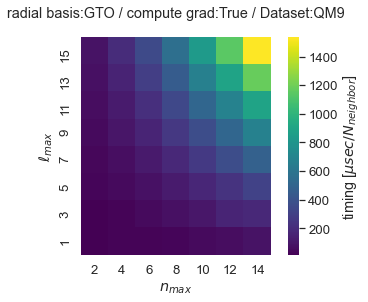

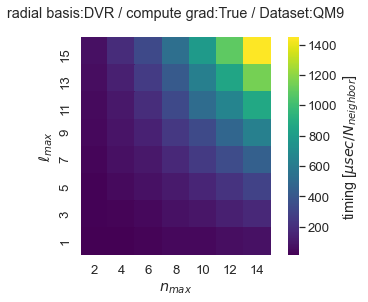

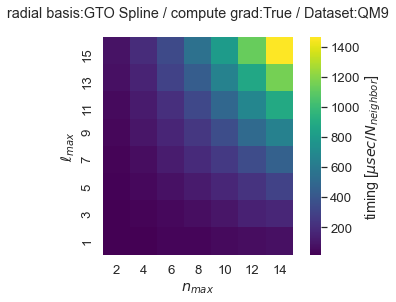

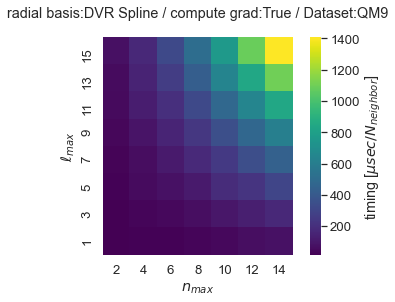

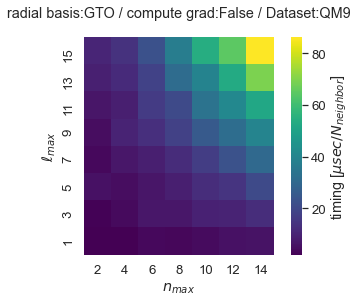

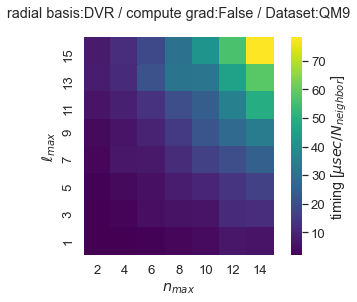

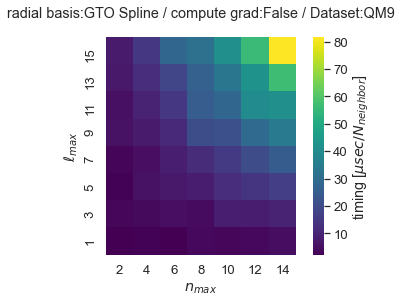

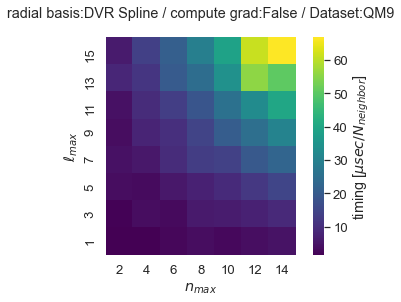

In [299]:
for df in dfs[label]:
    ax = format_contour(df,'$n_{max}$','$\ell_{max}$', 'timing [$\mu sec/N_{neighbor}$]', 
                               ['radial basis','compute grad','Dataset'])
    plt.show()




In [308]:
df

$\ell_{max}$  $n_{max}$ radial basis  compute grad Dataset  $\sigma$  \
0               5         12          GTO          True     QM9       0.3   
1              11          8          GTO          True     QM9       0.3   
2               5         10          GTO          True     QM9       0.3   
3               3          4          GTO          True     QM9       0.3   
4              11          4          GTO          True     QM9       0.3   
..            ...        ...          ...           ...     ...       ...   
107            13         12          GTO          True     QM9       0.3   
108             7          6          GTO          True     QM9       0.3   
109             7          4          GTO          True     QM9       0.3   
110            15          2          GTO          True     QM9       0.3   
111             7          8          GTO          True     QM9       0.3   

     elapsed_mean  elapsed_std  n_neighbors time_unit       mem_max mem_unit  \
0       29.693357     0.932876       112120   seconds  11114.292969      MiB   
1       35.706574     3.363539       112120   seconds  12595.410156      MiB   
2       22.454248     2.895548       112120   seconds   7968.156250      MiB   
3        3.059802     0.169033       112120   seconds   1054.113281      MiB   
4       13.393572     0.374901       112120   seconds   4258.171875      MiB   
..            ...          ...          ...       ...           ...      ...   
107    106.303506     2.442275       112120   seconds  30483.621094      MiB   
108     12.409051     0.388940       112120   seconds   4635.207031      MiB   
109      7.661384     0.274134       112120   seconds   2431.535156      MiB   
110     10.545394     0.262649       112120   seconds   2631.097656      MiB   
111     18.594101     0.709996       112120   seconds   7542.343750      MiB   

     timing [$\mu sec/N_{neighbor}$]  memory footprint [MiB]  
0                         264.835509            11114.292969  
1                         318.467484            12595.410156  
2                         200.269785             7968.156250  
3                          27.290421             1054.113281  
4                         119.457476             4258.171875  
..                               ...                     ...  
107                       948.122598            30483.621094  
108                       110.676513             4635.207031  
109                        68.332003             2431.535156  
110                        94.054528             2631.097656  
111                       165.841068             7542.343750  

[112 rows x 14 columns]

In [311]:
df['$n_{max}$']

0      12
1       8
2      10
3       4
4       4
       ..
107    12
108     6
109     4
110     2
111     8
Name: $n_{max}$, Length: 112, dtype: int64

In [320]:
sns.lmplot?

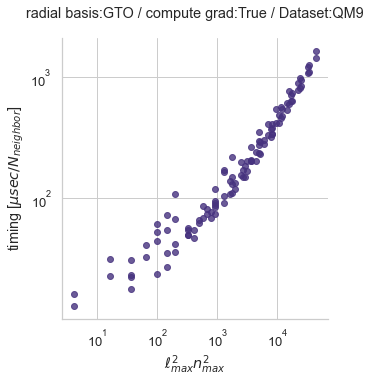

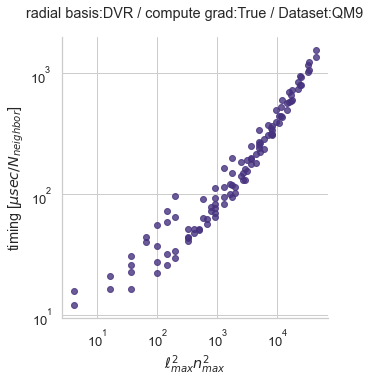

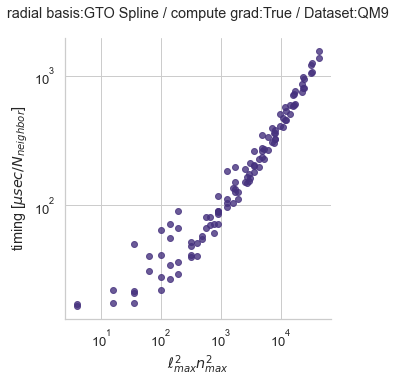

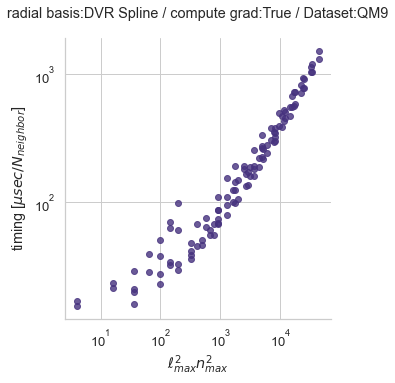

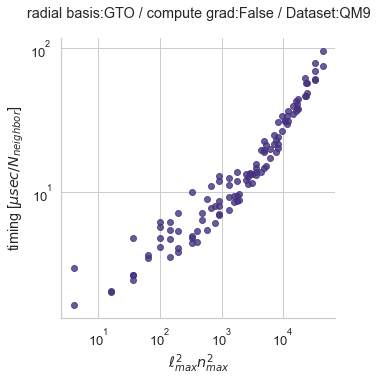

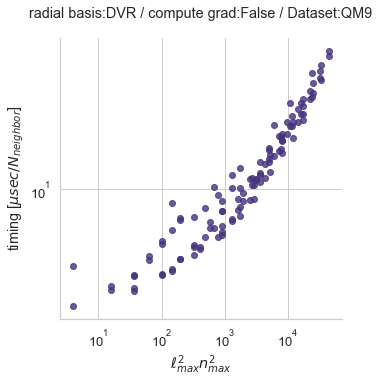

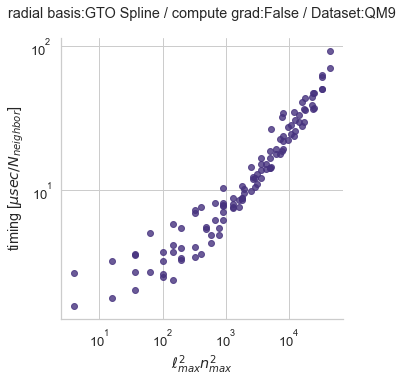

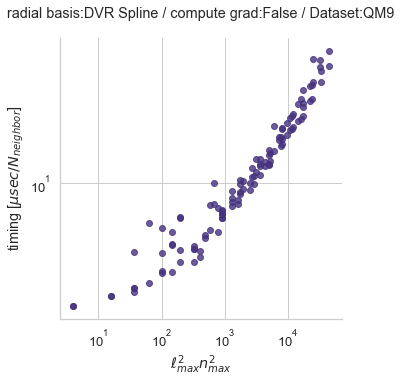

In [321]:
title_values = ['radial basis','compute grad','Dataset']
for df in dfs[label]:
    df['$\ell_{max}^2n_{max}^2$'] = df['$n_{max}$']**2 * df['$\ell_{max}$']**2
    sns.lmplot(x='$\ell_{max}^2n_{max}^2$', y='timing [$\mu sec/N_{neighbor}$]',
               height=5, data=df, palette=palette, fit_reg=False)
    # sns.lmplot(x='$n_{max}$', hue='$\ell_{max}$', y='timing [$\mu sec/N_{neighbor}$]',
    #            height=5, data=df, palette=palette)
    title = ' / '.join([k+':'+str(df.iloc[0][k]) for k in title_values])
    plt.title(title,pad=20)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
    

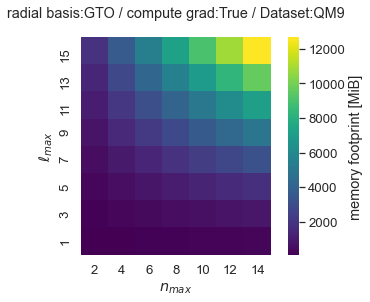

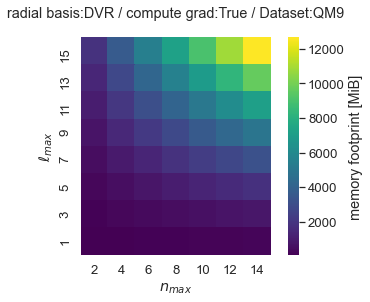

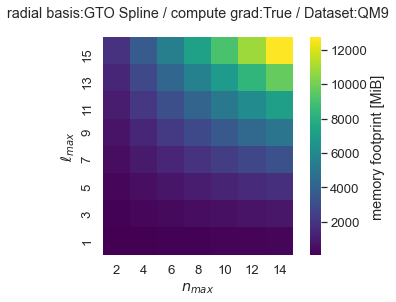

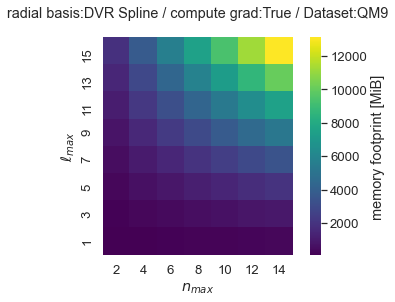

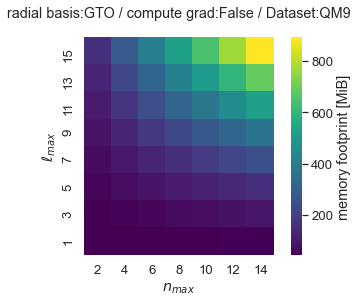

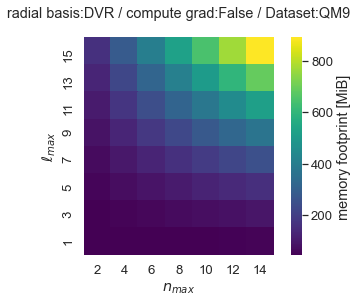

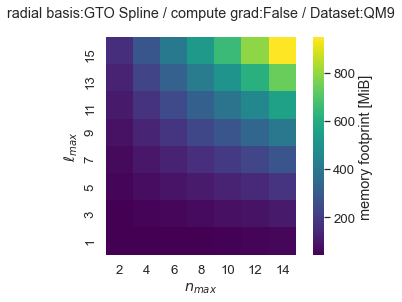

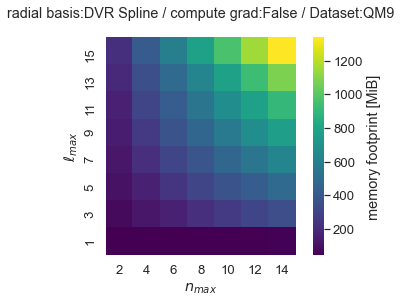

In [270]:
for df in dfs[label]:
    ax = format_contour(df,'$n_{max}$','$\ell_{max}$', 'memory footprint [MiB]', 
                               ['radial basis','compute grad','Dataset'])
    plt.show()

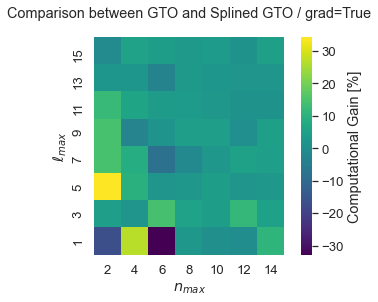

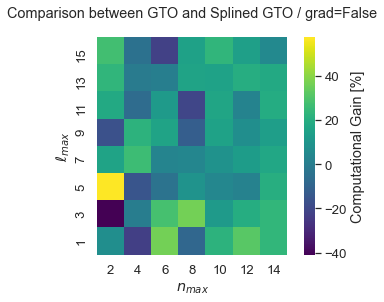

In [302]:
x = '$n_{max}$'
y = '$\ell_{max}$'
z = 'timing [$\mu sec/N_{neighbor}$]'
for data in dfs[label]:
    if data.iloc[0]['radial basis'] == 'GTO' and data.iloc[0]['compute grad'] == True:
        df1 = data.pivot_table(index=y, columns=x, 
                               values=z)
        df1 = df1.sort_index('index',ascending=False) 
    elif data.iloc[0]['radial basis'] == 'GTO Spline' and data.iloc[0]['compute grad'] == True:
        df2 = data.pivot_table(index=y, columns=x, 
                               values=z)
        df2 = df2.sort_index('index',ascending=False)
    if data.iloc[0]['radial basis'] == 'GTO' and data.iloc[0]['compute grad'] == False:
        df3 = data.pivot_table(index=y, columns=x, 
                               values=z)
        df3 = df3.sort_index('index',ascending=False) 
    elif data.iloc[0]['radial basis'] == 'GTO Spline' and data.iloc[0]['compute grad'] == False:
        df4 = data.pivot_table(index=y, columns=x, 
                               values=z)
        df4 = df4.sort_index('index',ascending=False) 
        
df = 100*(1-df2 / df1)
ax = sns.heatmap(df,cmap='viridis',square=True, cbar_kws={'label': 'Computational Gain [%]'})
title = 'Comparison between GTO and Splined GTO / grad=True'
ax.set_title(title,pad=20)
ax.set_xlabel(x)
ax.set_ylabel(y)
plt.show()

df = 100*(1-df4 / df3)
ax = sns.heatmap(df,cmap='viridis',square=True, cbar_kws={'label': 'Computational Gain [%]'})
title = 'Comparison between GTO and Splined GTO / grad=False'
ax.set_title(title,pad=20)
ax.set_xlabel(x)
ax.set_ylabel(y)
plt.show()

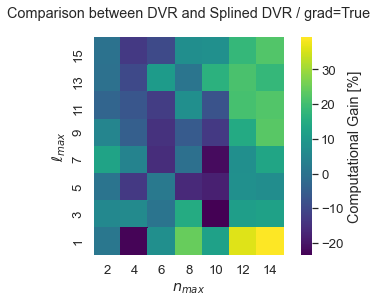

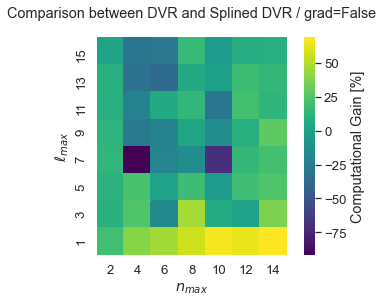

In [275]:
x = '$n_{max}$'
y = '$\ell_{max}$'
z = 'timing [$\mu sec/N_{neighbor}$]'
for data in dfs[label]:
    if data.iloc[0]['radial basis'] == 'DVR' and data.iloc[0]['compute grad'] == True:
        df1 = data.pivot_table(index=y, columns=x, 
                               values=z)
        df1 = df1.sort_index('index',ascending=False) 
    elif data.iloc[0]['radial basis'] == 'DVR Spline' and data.iloc[0]['compute grad'] == True:
        df2 = data.pivot_table(index=y, columns=x, 
                               values=z)
        df2 = df2.sort_index('index',ascending=False) 
    if data.iloc[0]['radial basis'] == 'DVR' and data.iloc[0]['compute grad'] == False:
        df3 = data.pivot_table(index=y, columns=x, 
                               values=z)
        df3 = df3.sort_index('index',ascending=False) 
    elif data.iloc[0]['radial basis'] == 'DVR Spline' and data.iloc[0]['compute grad'] == False:
        df4 = data.pivot_table(index=y, columns=x, 
                               values=z)
        df4 = df4.sort_index('index',ascending=False) 
df = 100*(1-df2 / df1)
ax = sns.heatmap(df,cmap='viridis',square=True, cbar_kws={'label': 'Computational Gain [%]'})
title = 'Comparison between DVR and Splined DVR / grad=True'
ax.set_title(title,pad=20)
ax.set_xlabel(x)
ax.set_ylabel(y)
plt.show()

df = 100*(1-df4 / df3)
ax = sns.heatmap(df,cmap='viridis',square=True, cbar_kws={'label': 'Computational Gain [%]'})
title = 'Comparison between DVR and Splined DVR / grad=False'
ax.set_title(title,pad=20)
ax.set_xlabel(x)
ax.set_ylabel(y)
plt.show()

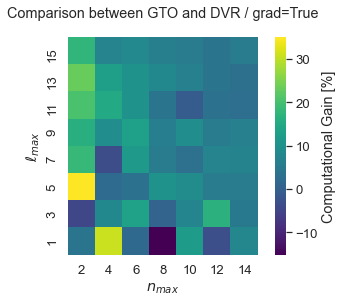

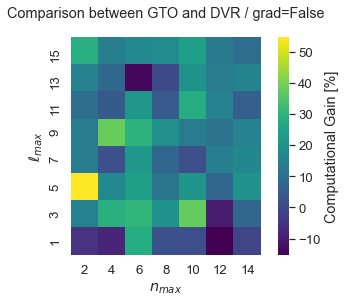

In [303]:
x = '$n_{max}$'
y = '$\ell_{max}$'
z = 'timing [$\mu sec/N_{neighbor}$]'
for data in dfs[label]:
    if data.iloc[0]['radial basis'] == 'GTO' and data.iloc[0]['compute grad'] == True:
        df1 = data.pivot_table(index=y, columns=x, 
                               values=z)
        df1 = df1.sort_index('index',ascending=False) 
    elif data.iloc[0]['radial basis'] == 'DVR' and data.iloc[0]['compute grad'] == True:
        df2 = data.pivot_table(index=y, columns=x, 
                               values=z)
        df2 = df2.sort_index('index',ascending=False) 
    if data.iloc[0]['radial basis'] == 'GTO' and data.iloc[0]['compute grad'] == False:
        df3 = data.pivot_table(index=y, columns=x, 
                               values=z)
        df3 = df3.sort_index('index',ascending=False) 
    elif data.iloc[0]['radial basis'] == 'DVR' and data.iloc[0]['compute grad'] == False:
        df4 = data.pivot_table(index=y, columns=x, 
                               values=z)
        df4 = df4.sort_index('index',ascending=False) 

df = 100*(1-df2 / df1)
ax = sns.heatmap(df,cmap='viridis',square=True, cbar_kws={'label': 'Computational Gain [%]'})
title = 'Comparison between GTO and DVR / grad=True'
ax.set_title(title,pad=20)
ax.set_xlabel(x)
ax.set_ylabel(y)
plt.show()

df = 100*(1-df4 / df3)
ax = sns.heatmap(df,cmap='viridis',square=True, cbar_kws={'label': 'Computational Gain [%]'})
title = 'Comparison between GTO and DVR / grad=False'
ax.set_title(title,pad=20)
ax.set_xlabel(x)
ax.set_ylabel(y)
plt.show()

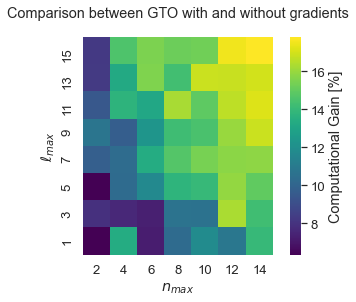

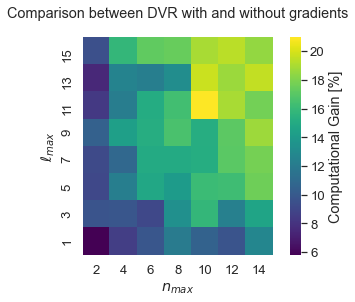

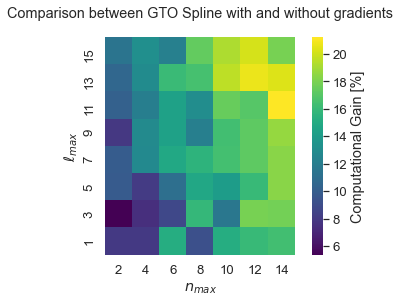

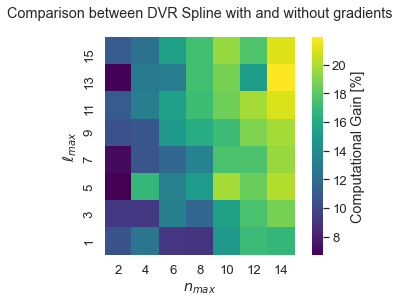

In [305]:
x = '$n_{max}$'
y = '$\ell_{max}$'
z = 'timing [$\mu sec/N_{neighbor}$]'
for rb in radial_basis:
    for data in dfs[label]:
        if data.iloc[0]['radial basis'] == rb and data.iloc[0]['compute grad'] == True:
            df1 = data.pivot_table(index=y, columns=x, 
                                   values=z)
            df1 = df1.sort_index('index',ascending=False) 
        elif data.iloc[0]['radial basis'] == rb and data.iloc[0]['compute grad'] == False:
            df2 = data.pivot_table(index=y, columns=x, 
                                   values=z)
            df2 = df2.sort_index('index',ascending=False) 
    # df = 100*(1-df2 / df1)
    df = df1 / df2
    ax = sns.heatmap(df,cmap='viridis',square=True, cbar_kws={'label': 'Computational Gain [%]'})
    title = 'Comparison between {} with and without gradients'.format(rb)
    ax.set_title(title,pad=20)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    plt.show()

## sparcification

In [116]:
sns.FacetGrid?

In [117]:
plt.errorbar?

In [111]:
def query(qry):
    project = signac.get_project(fn_projects['si'])
    data = []
    for job in project.find_jobs(qry):
        aa = {}
        aa['name'] = job.sp.name
        aa['$n_{max}$'] = job.sp.representation.max_radial
        aa['$\ell_{max}$'] = job.sp.representation.max_angular
        aa['NL'] = job.sp.nl_type
        aa['grad'] = job.sp.representation.compute_gradients
        aa['normalize'] = job.sp.representation.normalize
        aa['timing [ms/at]'] = job.document.elapsed_mean / job.document.n_centers *1000
        aa['error [ms/at]'] = job.document.elapsed_std / job.document.n_centers *1000
        aa['n_features'] = job.document.n_features
        data.append(aa)
    df = pd.DataFrame(data)
    df1 = df.sort_values('n_features')
    return df1

def plot(df, x, y, err , row, col, hue, **kwargs):
    g = sns.FacetGrid(df, col=col, row=row, hue=hue, height=5, **kwargs)
    g.map(plt.errorbar, x, y, err, marker="o", linestyle='--')
    plt.legend(title=hue,loc='upper right', bbox_to_anchor=(1.25, 1))
    return g

In [103]:
names = [
    'qm9',
    'molecular_crystals',
    'silicon_bulk',
    'methane_liquid',
    'methane_sulfonic',
]
nl_types = ['Half', 'Full']
normalize = [False, True]
qrys = []
qry = {
    'representation.coefficient_subselection':{'$ne':None},
       'representation.max_radial':{'$eq':10}, 
       'representation.compute_gradients':{'$eq':True},
       'representation.max_angular':{'$eq':11}, 
}

df = query(qry)    

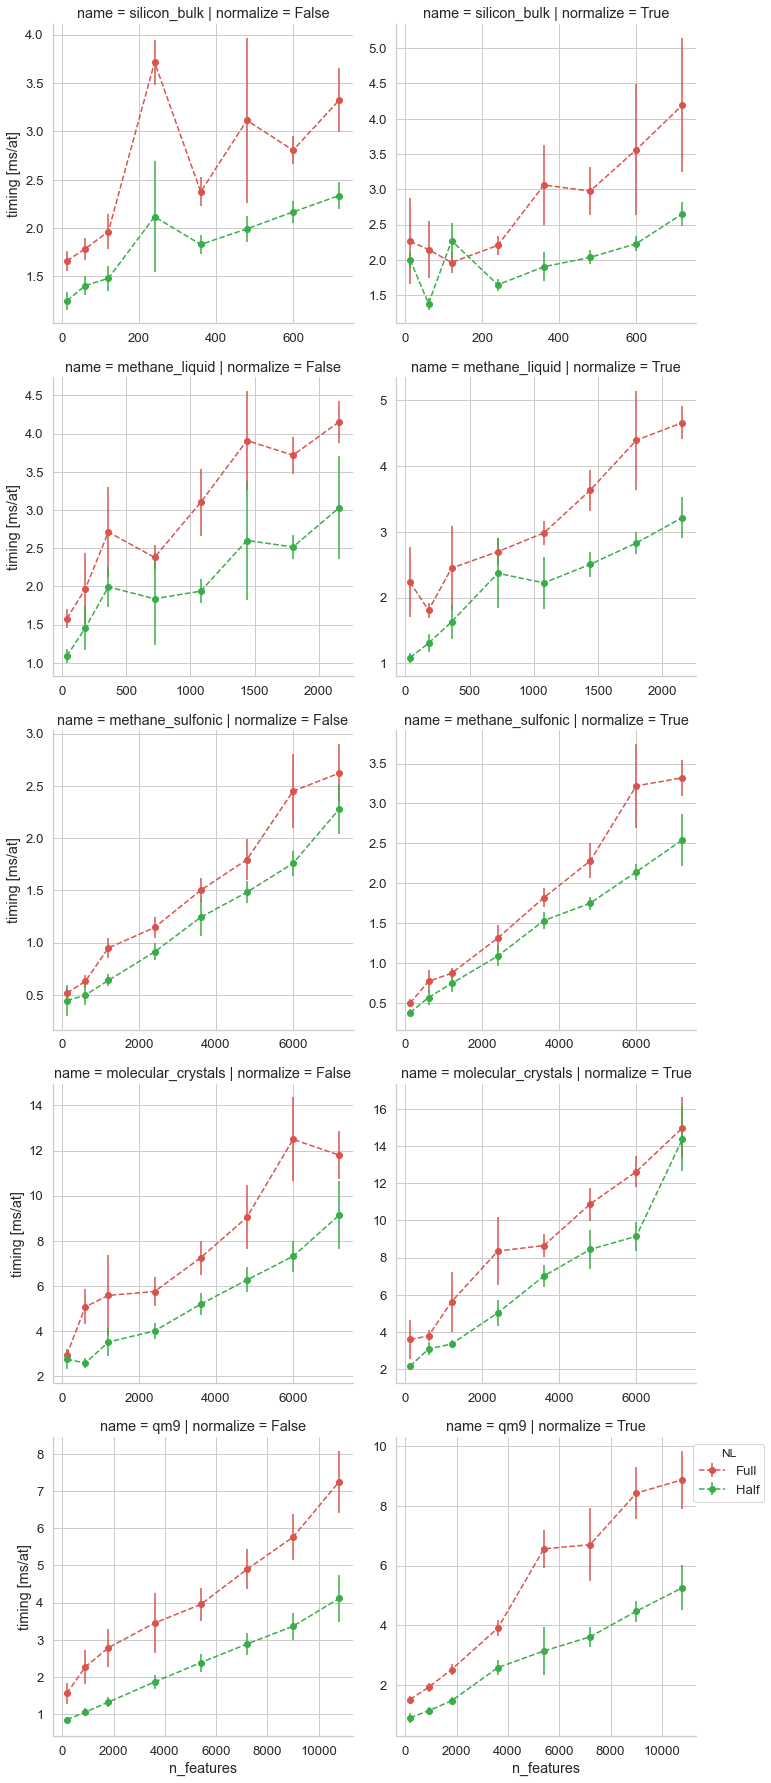

In [124]:
kwargs = dict(sharex=False, sharey=False,legend_out=True,palette=palette)
plot(df, x='n_features', y='timing [ms/at]', err='error [ms/at]',row='name', col='normalize',  hue='NL', **kwargs)

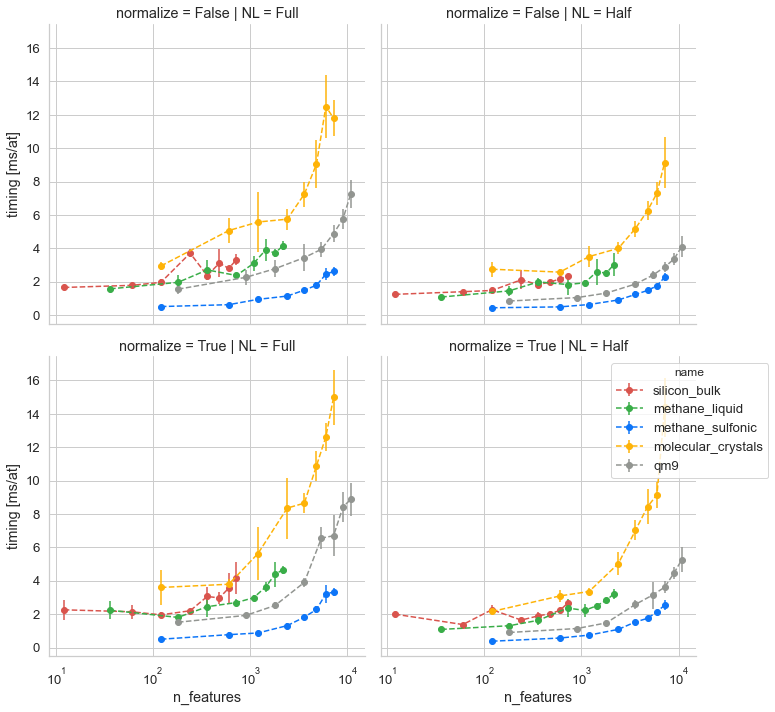

In [123]:
kwargs = dict(sharex=True, sharey=True,legend_out=True,palette=palette)
g = plot(df, x='n_features', y='timing [ms/at]', err='error [ms/at]',row='normalize', col='NL',  hue='name', **kwargs)
for ax in g.axes.flatten():
    ax.set_xscale('log')